# Trade profile of a country

Trade profile of a country. Analysis of trade balances, main exports and imports, main trade partners and main competitors.

More info in [country_trade_profile_README_EN.md](country_trade_profile_README_EN.md)

## Setup

For instructions and how to obtain an API key, see [here](0-comtrade-setup-first.ipynb).

In [97]:
import logging
import sys

# Configure logging to output to stdout and set level to DEBUG or INFO
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Example info message
logging.info("This is an info message")
# Example debug message
logging.debug("This is a debug message")

INFO:root:This is an info message


In [98]:
import comtradetools as comtradetools

comtradetools.setup()
APIKEY = comtradetools.get_api_key()
comtradetools.init(APIKEY, force_init=False)


In [99]:
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

## Country and period of interest

Choose country and years of interest

In [100]:
import comtradetools


country_of_interest_name = 'Mozambique'
country_of_interest = comtradetools.encode_country(country_of_interest_name)

years_of_interest=comtradetools.year_range(2003,2023)
print(country_of_interest_name, country_of_interest, years_of_interest)

Mozambique 508 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [101]:
from datetime import datetime

current_datetime = datetime.now()
print(f"Start run for {country_of_interest_name}:", current_datetime)

Start run for Mozambique: 2025-04-19 04:46:43.179168


## 1.Trade balance

### 1a Trade balance symmetric values

In [102]:
import comtradetools
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

global_trade = comtradetools.get_trade_flows(country_of_interest,
                                        period=years_of_interest,
                                        period_size=1,  # how may years fetched in one call
                                        retry_if_empty=False,
                                        symmetric_values=True)

cols_of_interest = global_trade.columns



INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Usi

/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns 

INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Using cached results for period 2013
INFO:root:Calling getFinalData for period 2014
INFO:root:Using cached results for period 2014
INFO:root:Cal

/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


In [103]:
global_trade['varM_perc']=global_trade['M<X']/global_trade['M<X']
global_trade['varX_perc']=global_trade['X<M']/global_trade['X<M']
print(f"M = Imports as reported by {country_of_interest_name}")
print(f"X = Exports as reported by {country_of_interest_name}")
print(f"X<M = Exports as imports from {country_of_interest_name} reported by rest of the world")
print(f"M<X = Imports as exports to {country_of_interest_name} reported by rest of the world")
global_trade


M = Imports as reported by Mozambique
X = Exports as reported by Mozambique
X<M = Exports as imports from Mozambique reported by rest of the world
M<X = Imports as exports to Mozambique reported by rest of the world


flowCode,M,M<X,X,X<M,trade_balance (X-M),trade_balance (X<M-M),trade_balance (X<M-M<X),trade_volume (X+M),trade_volume (X<M+M),trade_volume (X<M+M<X),varM_perc,varX_perc
period,,,,,,,,,,,,
2003,"1,752,997,456.00","1,702,369,468.82","1,043,912,538.00","1,093,528,127.23","-709,084,918.00","-659,469,328.77","-608,841,341.59","2,796,909,994.00","2,846,525,583.23","2,795,897,596.05",1.00,1.00
2004,"2,034,671,767.00","2,198,506,285.68","1,503,846,229.00","1,676,851,731.27","-530,825,538.00","-357,820,035.73","-521,654,554.41","3,538,517,996.00","3,711,523,498.27","3,875,358,016.95",1.00,1.00
2005,"2,408,195,310.00","2,488,115,730.11","1,745,256,187.00","2,114,760,461.08","-662,939,123.00","-293,434,848.92","-373,355,269.02","4,153,451,497.00","4,522,955,771.08","4,602,876,191.19",1.00,1.00
2006,"2,869,326,549.00","2,761,122,522.56","2,381,131,616.00","2,603,114,796.42","-488,194,933.00","-266,211,752.58","-158,007,726.14","5,250,458,165.00","5,472,441,345.42","5,364,237,318.99",1.00,1.00
2007,"3,049,746,128.00","3,709,286,864.98","2,412,078,629.00","3,183,662,092.70","-637,667,499.00","133,915,964.70","-525,624,772.28","5,461,824,757.00","6,233,408,220.70","6,892,948,957.68",1.00,1.00
2008,"4,007,763,192.00","4,323,369,174.98","2,653,259,648.00","2,832,457,927.62","-1,354,503,544.00","-1,175,305,264.38","-1,490,911,247.36","6,661,022,840.00","6,840,221,119.62","7,155,827,102.60",1.00,1.00
2009,"3,764,206,586.00","4,456,063,348.64","2,147,169,453.00","2,507,283,755.04","-1,617,037,133.00","-1,256,922,830.96","-1,948,779,593.60","5,911,376,039.00","6,271,490,341.04","6,963,347,103.68",1.00,1.00
2010,"3,564,229,509.00","5,279,513,515.80","2,243,068,881.00","3,012,998,182.53","-1,321,160,628.00","-551,231,326.47","-2,266,515,333.27","5,807,298,390.00","6,577,227,691.53","8,292,511,698.34",1.00,1.00
2011,"6,305,647,000.00","7,217,084,396.47","3,604,118,000.00","3,801,998,090.05","-2,701,529,000.00","-2,503,648,909.95","-3,415,086,306.42","9,909,765,000.00","10,107,645,090.05","11,019,082,486.51",1.00,1.00


Save to Excel file

In [104]:
start_year=global_trade.index.min()
end_year=global_trade.index.max()
excel_file = f"reports/{country_of_interest_name}_1.1_trade_balance_{start_year}-{end_year}.xlsx"
global_trade.to_excel(excel_file)
print("Trade balance report saved to ", excel_file)

Trade balance report saved to  reports/Mozambique_1.1_trade_balance_2003-2023.xlsx


### Trade balance graph

Plot saved to  reports/Mozambique_1.2_trade_balance_2003-2023.png
0 Line2D(M) 0.0
1 Line2D(M<X) 0.8
2 Line2D(X) 0.0
3 Line2D(X<M) 0.8
4 Line2D(trade_balance (X-M)) 0.0
5 Line2D(trade_balance (X<M-M)) 0.8
6 Line2D(trade_balance (X<M-M<X)) 0.0
7 Line2D(trade_volume (X+M)) 0.8
8 Line2D(trade_volume (X<M+M)) 0.0
9 Line2D(trade_volume (X<M+M<X)) 0.8


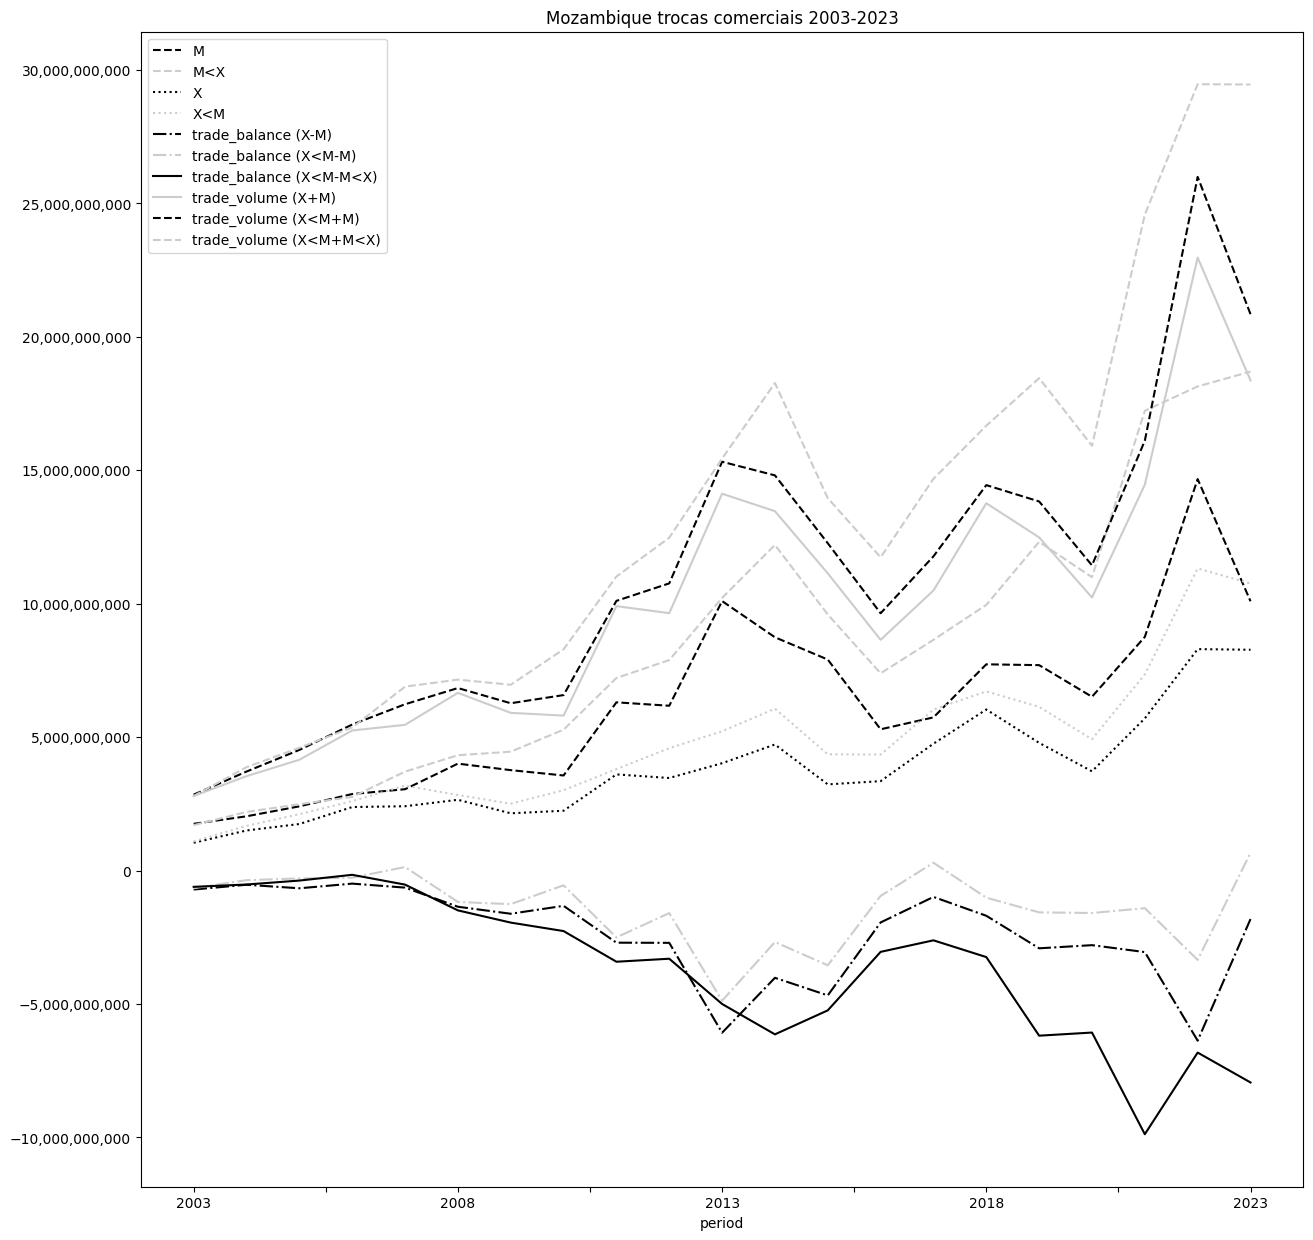

In [105]:
import logging

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
logging.basicConfig(level=logging.ERROR)

plotfile = f"reports/{country_of_interest_name}_1.2_trade_balance_{start_year}-{end_year}.png"

start_year=global_trade.index.min()
end_year=global_trade.index.max()
title=f"{country_of_interest_name} trocas comerciais {start_year}-{end_year}"
print("Plot saved to ", plotfile)
fig = global_trade[cols_of_interest].plot.line(figsize=(15,15),title=title)

# use a grayscale palette of colors
colors = ['0.0','0.8','0.0','0.8','0.0','0.8','0.0','0.8']

# use different line styles and black lines
linestyles = ['dashed', 'dashed', 'dotted', 'dotted', 'dashdot', 'dashdot', 'solid', 'solid']
for i, line in enumerate(fig.get_lines()):
    color = colors[i % len(colors)]
    print(i, line, color)
    line.set_color(color)
    line.set_linestyle(linestyles[i % len(linestyles)])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig.yaxis.set_major_formatter(formatter)
fig.legend(list(global_trade.columns.astype(str)))

plt.savefig(plotfile)
plt.show()

## 2. Exports


### 2.1 Main export partners/clients

Colect destinations of exports of the country. 

Use either reported exports
of country of interest, or reported imports from country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [106]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
    filename_symmetric_flag="reverse"
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'
    filename_symmetric_flag="direct"

In [107]:

df = comtradetools.getFinalData(APIKEY,
                                reporterCode=reporterCode,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode=flowCode,
                                period=years_of_interest,
                                period_size=1,
                                partnerCode=partnerCode,
                                remove_world=True,
                                partner2Code=0,  # world
                                clCode="HS",
                                cmdCode="TOTAL",
                                motCode=0,  # all means of transport
                                customsCode='C00', # all customs
                                includeDesc=True,
                                retry_if_empty=False,
                                cache=True
                                )

INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Usi

Compute percentage of trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [108]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5

# aggregate by year, flow, reporter
exports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode',f'{reporter_column}Desc','partner_rank',f'{partner_column}Desc','cmdCode','partner_sum','partner_perc','partner_upper_sum']

formats =  comtradetools.make_format(cols)

top_export_partners = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_export_partners_codes = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} export partners of {country_of_interest_name} in {years_of_interest}: \n{top_export_partners}")
exports[exports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).style.format(formats)

Top 5 export partners of Mozambique in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['Belgium' 'Germany' 'Italy' 'Spain' 'United Kingdom' 'Malawi' 'Zimbabwe'
 'South Africa' 'China' 'India' 'Zambia' 'United Arab Emirates'
 'Rep. of Korea']


,refYear,flowCode,partnerDesc,partner_rank,reporterDesc,cmdCode,partner_sum,partner_perc,partner_upper_sum
6,2003,M,Mozambique,1,Belgium,TOTAL,"$309,987,179",28.347%,"$1,093,528,127"
44,2003,M,Mozambique,2,Italy,TOTAL,"$111,944,877",10.237%,"$1,093,528,127"
87,2003,M,Mozambique,3,Spain,TOTAL,"$109,214,610",9.987%,"$1,093,528,127"
33,2003,M,Mozambique,4,Germany,TOTAL,"$97,394,000",8.906%,"$1,093,528,127"
99,2003,M,Mozambique,5,United Kingdom,TOTAL,"$46,182,380",4.223%,"$1,093,528,127"
112,2004,M,Mozambique,1,Belgium,TOTAL,"$468,464,105",27.937%,"$1,676,851,731"
149,2004,M,Mozambique,2,Italy,TOTAL,"$211,706,835",12.625%,"$1,676,851,731"
186,2004,M,Mozambique,3,Spain,TOTAL,"$185,612,205",11.069%,"$1,676,851,731"
139,2004,M,Mozambique,4,Germany,TOTAL,"$151,711,000",9.047%,"$1,676,851,731"
159,2004,M,Mozambique,5,Malawi,TOTAL,"$125,934,108",7.510%,"$1,676,851,731"


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [109]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna(0,inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)


Limit table to top_export_partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [110]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
pivoted[show_only_columns].fillna(0)

partner_perc                                                 \
reporterDesc          Belgium China Germany India Italy Malawi Rep. of Korea   
refYear flowDesc                                                               
2003    Import           0.28  0.02    0.09  0.02  0.10   0.04          0.00   
2004    Import           0.28  0.03    0.09  0.02  0.13   0.08          0.00   
2005    Import           0.24  0.03    0.07  0.02  0.11   0.07          0.00   
2006    Import           0.22  0.03    0.06  0.01  0.16   0.06          0.00   
2007    Import           0.17  0.04    0.05  0.01  0.18   0.05          0.00   
2008    Import           0.10  0.04    0.05  0.02  0.14   0.10          0.00   
2009    Import           0.12  0.07    0.04  0.02  0.09   0.10          0.00   
2010    Import           0.06  0.07    0.06  0.03  0.15   0.01          0.00   
2011    Import           0.01  0.07    0.05  0.03  0.12   0.01          0.01   
2012    Import           0.02  0.09    0.04  0.06  0.08   0.05          0.01   
2013    Import           0.02  0.09    0.04  0.05  0.09   0.07          0.00   
2014    Import           0.01  0.27    0.03  0.05  0.07   0.05          0.00   
2015    Import           0.01  0.10    0.04  0.08  0.09   0.02          0.00   
2016    Import           0.00  0.11    0.04  0.09  0.09   0.01          0.01   
2017    Import           0.00  0.09    0.04  0.16  0.08   0.01          0.02   
2018    Import           0.00  0.09    0.04  0.15  0.08   0.01          0.04   
2019    Import           0.00  0.12    0.05  0.14  0.07   0.01          0.03   
2020    Import           0.00  0.12    0.03  0.14  0.07   0.02          0.03   
2021    Import           0.00  0.16    0.03  0.20  0.06   0.01          0.03   
2022    Import           0.00  0.12    0.02  0.22  0.08   0.00          0.05   
2023    Import           0.00  0.16    0.02  0.16  0.04   0.01          0.07   

                                                          ...  \
reporterDesc     South Africa Spain United Arab Emirates  ...   
refYear flowDesc                                          ...   
2003    Import           0.03  0.10                 0.00  ...   
2004    Import           0.02  0.11                 0.00  ...   
2005    Import           0.01  0.12                 0.00  ...   
2006    Import           0.02  0.10                 0.00  ...   
2007    Import           0.11  0.12                 0.00  ...   
2008    Import           0.14  0.10                 0.00  ...   
2009    Import           0.17  0.07                 0.00  ...   
2010    Import           0.17  0.08                 0.00  ...   
2011    Import           0.28  0.09                 0.01  ...   
2012    Import           0.28  0.06                 0.02  ...   
2013    Import           0.24  0.06                 0.02  ...   
2014    Import           0.17  0.05                 0.01  ...   
2015    Import           0.19  0.04                 0.02  ...   
2016    Import           0.16  0.04                 0.03  ...   
2017    Import           0.15  0.04                 0.03  ...   
2018    Import           0.15  0.04                 0.04  ...   
2019    Import           0.15  0.04                 0.05  ...   
2020    Import           0.13  0.05                 0.07  ...   
2021    Import           0.11  0.03                 0.07  ...   
2022    Import           0.08  0.04                 0.08  ...   
2023    Import           0.09  0.02                 0.06  ...   

                     primaryValue                                \
reporterDesc                India          Italy         Malawi   
refYear flowDesc                                                  
2003    Import      23,644,566.00 111,944,877.28  41,986,168.55   
2004    Import      36,999,858.00 211,706,835.09 125,934,107.94   
2005    Import      51,728,964.00 232,198,298.07 148,391,313.15   
2006    Import      32,870,989.00 424,495,868.11 151,671,201.26   
2007    Import      30,132,266.00 585,425,645.52 166,453,218.93   

Make a table with the total value of exports for top partners in the period of interest

In [111]:
print("Top partners for exports: ",top_export_partners)
print("Period of interest:",years_of_interest)

Top partners for exports:  ['Belgium' 'Germany' 'Italy' 'Spain' 'United Kingdom' 'Malawi' 'Zimbabwe'
 'South Africa' 'China' 'India' 'Zambia' 'United Arab Emirates'
 'Rep. of Korea']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [112]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_export_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

reporterDesc,South Africa,India,China,Italy,Spain,Germany,Belgium,United Arab Emirates,Zimbabwe,Malawi,Rep. of Korea,United Kingdom,Zambia
refYear,,,,,,,,,,,,,
2003,"37,096,025.00","23,644,566.00","26,591,793.00","111,944,877.28","109,214,610.48","97,394,000.00","309,987,179.00","866,826.00","30,867,864.41","41,986,168.55","272,510.00","46,182,380.00","10,954,141.00"
2004,"31,209,386.00","36,999,858.00","44,286,108.00","211,706,835.09","185,612,205.39","151,711,000.00","468,464,105.00","680,178.00","107,677,052.14","125,934,107.94","83,131.00","90,748,881.00","2,172,031.00"
2005,"30,331,449.00","51,728,964.00","73,527,324.00","232,198,298.07","252,592,699.51","153,576,000.00","509,814,026.00","3,923,708.00","162,428,871.58","148,391,313.15","130,678.00","132,043,768.00","10,501,066.00"
2006,"47,610,611.00","32,870,989.00","79,772,228.00","424,495,868.11","254,353,492.00","150,101,000.00","565,927,641.00","1,096,153.00","184,880,101.25","151,671,201.26","572,939.00","242,061,292.00","16,569,601.00"
2007,"340,048,461.00","30,132,266.00","124,248,069.00","585,425,645.52","376,921,579.39","156,638,000.00","555,464,121.00","4,229,379.00","123,124,046.99","166,453,218.93","1,829,944.00","220,041,230.00","59,205,080.00"
2008,"398,463,870.00","57,084,987.00","125,882,374.00","383,284,005.07","294,575,790.25","133,299,129.60","296,632,807.00","2,728,924.00","65,886,252.43","278,915,661.84","2,386,711.00","134,438,608.00","51,193,078.48"
2009,"420,011,728.00","43,586,595.00","177,554,369.00","224,170,237.57","184,565,725.80","100,452,724.82","294,796,988.00","6,477,390.00","104,571,587.47","259,234,854.31","4,518,147.00","71,444,555.00","37,858,830.56"
2010,"526,391,644.05","86,736,461.00","201,077,529.00","440,193,375.00","252,943,605.32","185,996,963.06","173,450,282.42","5,852,122.00","164,727,816.00","29,192,014.72","6,339,577.00","108,717,242.00","16,518,179.68"
2011,"1,052,718,850.37","122,543,641.00","257,241,199.00","459,792,365.00","329,376,340.79","179,208,969.27","35,463,959.13","19,488,115.00","168,770,416.91","45,139,755.18","23,774,943.00","124,483,996.00","19,028,313.31"


Plot saved to  reports/Mozambique_2.1.4_export_2003-2023_reverse.png
0 Line2D(_child0) #555555
1 Line2D(_child2) #666666
2 Line2D(_child4) #777777
3 Line2D(_child6) #888888
4 Line2D(_child8) #999999
5 Line2D(_child10) #AAAAAA
6 Line2D(_child12) #BBBBBB
7 Line2D(_child14) #CCCCCC
8 Line2D(_child16) #555555
9 Line2D(_child18) #666666
10 Line2D(_child20) #777777
11 Line2D(_child22) #888888
12 Line2D(_child24) #999999


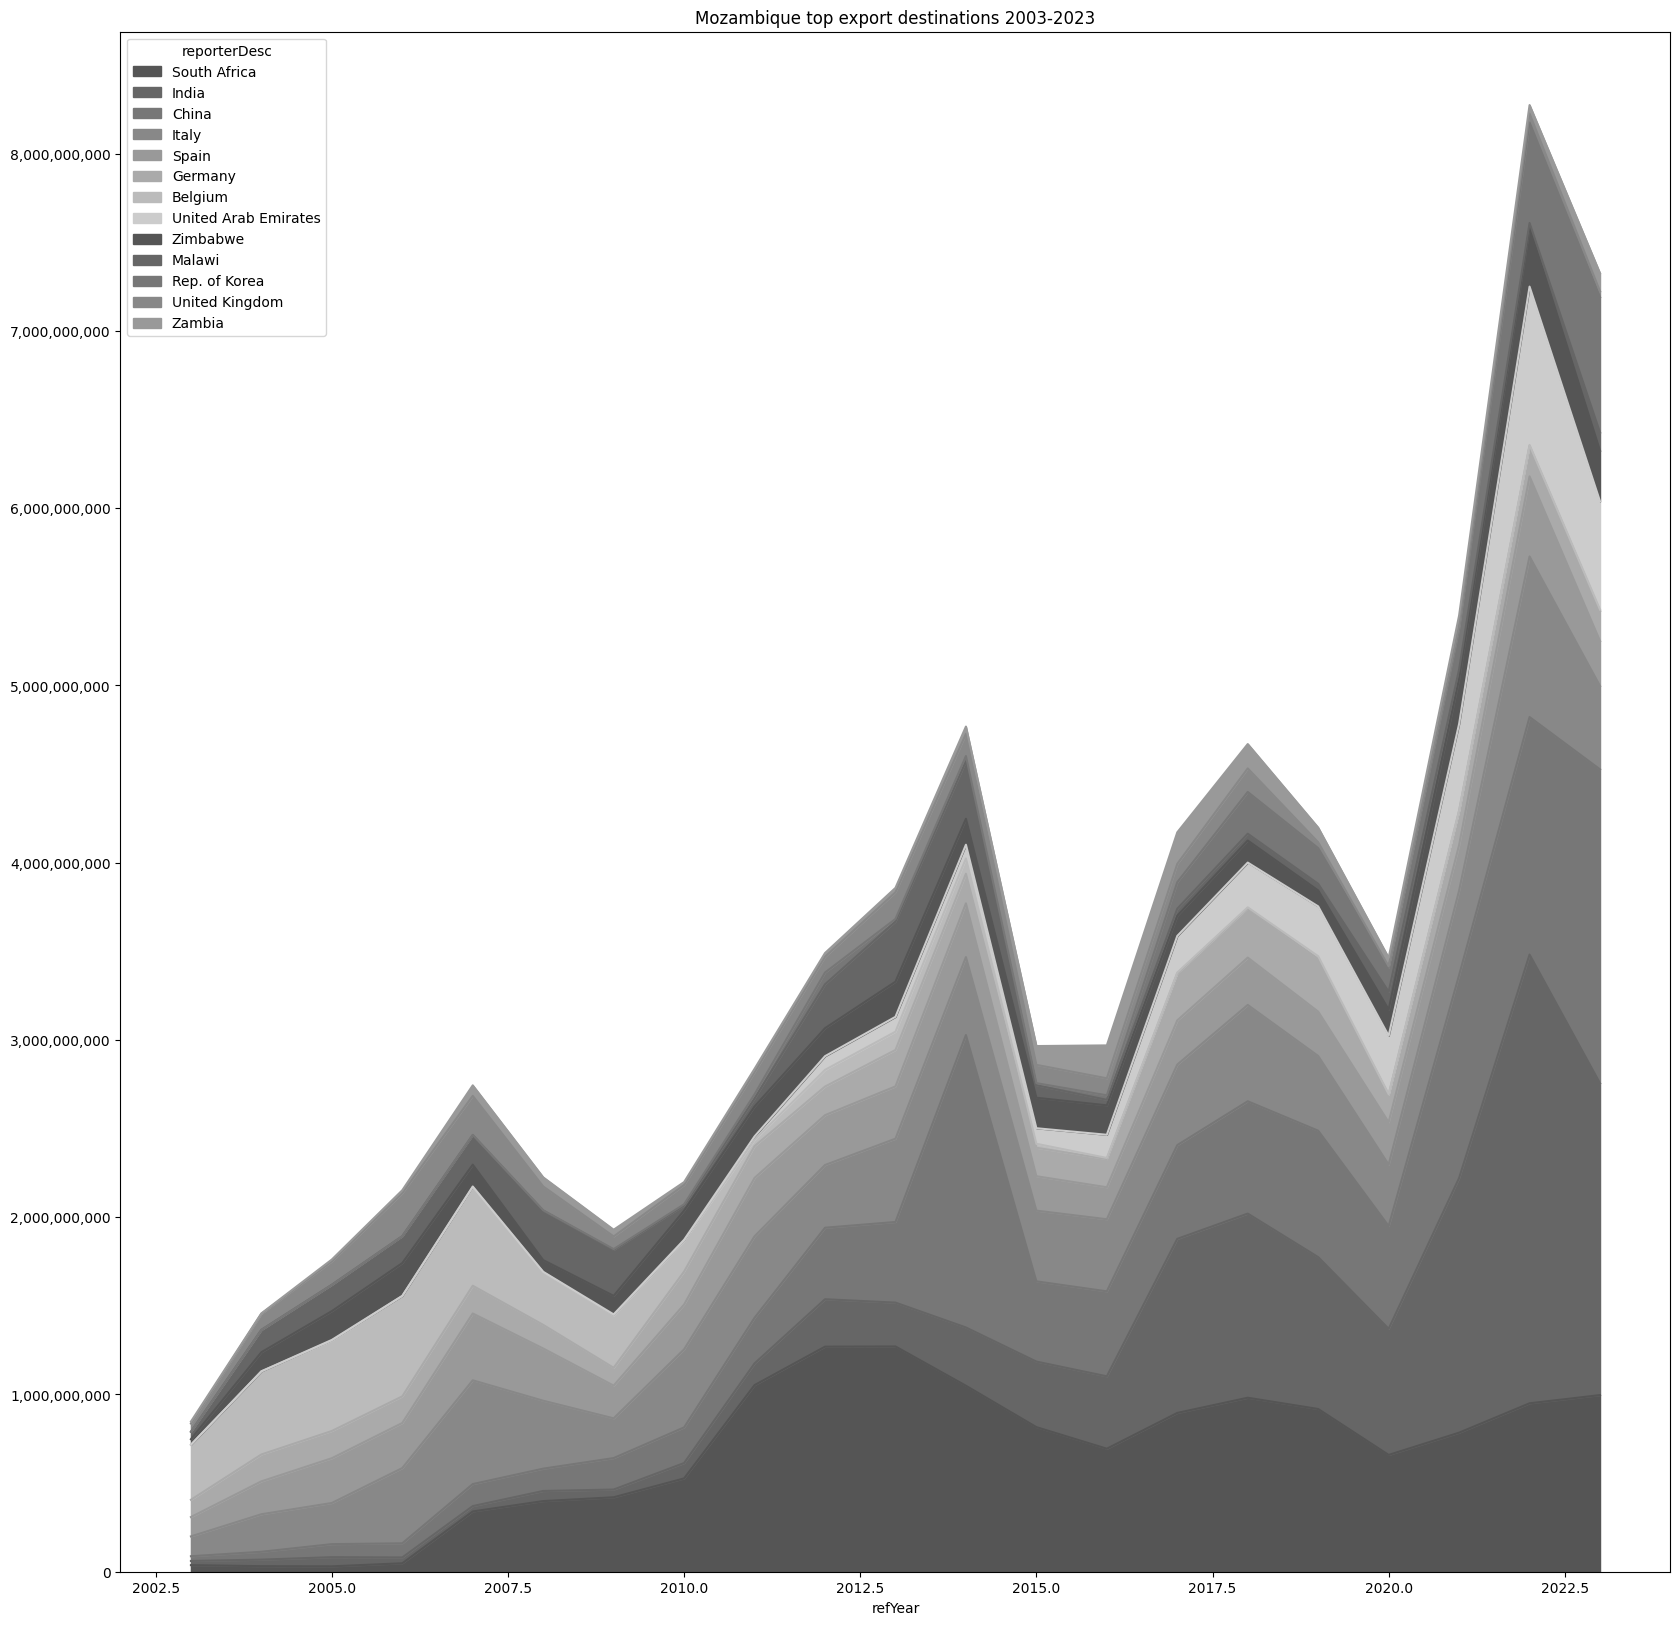

In [113]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plotfile = f"reports/{country_of_interest_name}_2.1.4_export_{start_year}-{end_year}_{filename_symmetric_flag}.png"
start_year=values_only.index.min()
end_year=values_only.index.max()
title=f"{country_of_interest_name} top export destinations {start_year}-{end_year}"
print("Plot saved to ", plotfile)
# see https://matplotlib.org/stable/gallery/color/named_colors.html
# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = [ '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', ]

fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)
for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

#### Export to Excel

Table with the top export destinations for the period of interest

In [114]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]

top_partners_file = f'reports/{country_of_interest_name}_2.1.1_top_export_partners_{filename_symmetric_flag}.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_2.1.2_top_export_partners_cols_{filename_symmetric_flag}.xlsx'
export_top_partners_file = f'reports/{country_of_interest_name}_2.1.3_export_top_{show_only_top}_partners_{start_year}-{end_year}_{filename_symmetric_flag}.xlsx'

exports[cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].to_excel(export_top_partners_file)

print(f"Top partners file: {top_partners_file}")
print(f"Top partners cols file: {top_partners_cols_file}")
print(f"Export top partners file: {export_top_partners_file}")

Top partners file: reports/Mozambique_2.1.1_top_export_partners_reverse.xlsx
Top partners cols file: reports/Mozambique_2.1.2_top_export_partners_cols_reverse.xlsx
Export top partners file: reports/Mozambique_2.1.3_export_top_5_partners_2003-2023_reverse.xlsx


### 2.2 Exports: products

#### What are the main exported products

In [115]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5

print(country_of_interest_name, years_of_interest)

Mozambique 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products exported by country of interest

In [116]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # use mode from previous cells

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
    filename_symmetric_flag="reverse"
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'
    filename_symmetric_flag="direct"

filename_symmetric_flag

'reverse'

In [117]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World Bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True

                        )

INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Usi

In [118]:
print("Years available in the data:", df.refYear.unique())

Years available in the data: [2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]


In [119]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20030101,2003,52,2003,68,BOL,Bolivia (Plurinational State of),M,...,11.22,True,76.00,False,421.00,100.00,421.00,4,False,True
1,C,A,20030101,2003,52,2003,56,BEL,Belgium,M,...,"1,638.00",False,NaN,False,"35,556.00",NaN,"35,556.00",0,True,False
2,C,A,20030101,2003,52,2003,56,BEL,Belgium,M,...,"127,074.00",False,NaN,False,"1,240,615.00",NaN,"1,240,615.00",0,True,False
3,C,A,20030101,2003,52,2003,72,BWA,Botswana,M,...,624.00,False,NaN,False,"2,303.00",NaN,"2,303.00",0,False,False
4,C,A,20030101,2003,52,2003,56,BEL,Belgium,M,...,"2,174.00",False,NaN,False,"10,112.00",NaN,"10,112.00",0,True,False


Agreggate by product, keep the top products exported each year

In [120]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
exports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
exports = exports[exports['product_rank']<=show_only_top]
exports.info()

cols=['refYear','flowCode','product_rank','cmdCode', 'cmdDesc','product_sum','product_upper_perc', 'product_upper_sum']
formats =  comtradetools.make_format(cols)

top_export_products_codes = exports['cmdCode'].unique()

print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
exports[cols].sort_values(['refYear','flowCode','product_rank']).head(10).style.format(formats)


<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 2 to 74646
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  105 non-null    object 
 1   freqCode                  105 non-null    object 
 2   refPeriodId               105 non-null    int64  
 3   refYear                   105 non-null    int64  
 4   refMonth                  105 non-null    int64  
 5   period                    105 non-null    object 
 6   reporterCode              105 non-null    int64  
 7   reporterISO               105 non-null    object 
 8   reporterDesc              105 non-null    object 
 9   flowCode                  105 non-null    object 
 10  flowDesc                  105 non-null    object 
 11  partnerCode               105 non-null    int64  
 12  partnerISO                105 non-null    object 
 13  partnerDesc               105 non-null    object 
 14  partner2Code 

,refYear,flowCode,product_rank,cmdCode,cmdDesc,product_sum,product_upper_perc,product_upper_sum
47,2003,M,1,760110,"Aluminium; unwrought, (not alloyed)","$586,214,981",53.701%,"$1,091,624,307"
2,2003,M,2,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)","$83,417,826",7.642%,"$1,091,624,307"
165,2003,M,3,760120,"Aluminium; unwrought, alloys","$65,738,578",6.022%,"$1,091,624,307"
24,2003,M,4,271600,Electrical energy,"$41,191,515",3.773%,"$1,091,624,307"
15,2003,M,5,240120,Tobacco; partly or wholly stemmed or stripped,"$40,427,337",3.703%,"$1,091,624,307"
2175,2004,M,1,760110,"Aluminium; unwrought, (not alloyed)","$987,894,622",58.958%,"$1,675,579,591"
2177,2004,M,2,760120,"Aluminium; unwrought, alloys","$93,402,942",5.574%,"$1,675,579,591"
2682,2004,M,3,271011,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations","$89,511,811",5.342%,"$1,675,579,591"
2032,2004,M,4,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)","$78,143,560",4.664%,"$1,675,579,591"
2048,2004,M,5,240120,Tobacco; partly or wholly stemmed or stripped,"$44,775,709",2.672%,"$1,675,579,591"


#### Export to Excel

In [121]:
filename = f'reports/{country_of_interest_name}_2.2_exports_{clCode}-{cmdDetail}-{exports["refYear"].min()}-{exports["refYear"].max()}_{filename_symmetric_flag}.xlsx'
print("Exporting to ",filename)
exports[cols].sort_values(['refYear','flowCode','product_rank']).to_excel(filename,index=False)

Exporting to  reports/Mozambique_2.2_exports_HS-AG6-2003-2023_reverse.xlsx


### 2.3 Export partners / products analysis

Which are the partners buying the top exports of country of interest?


In [122]:

# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # we keep the previous choice

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
    filename_symmetric_flag="reverse"
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'
    filename_symmetric_flag="direct"

filename_symmetric_flag

'reverse'

#### Caveat

Simmetrical reporting can vary greatly from direct reporting.

Example:

Mozambique exports to Netherlands in 2008

#### Analyse assymetric reporting (optional)

Choose pair of countries and a year to compare exports with partner imports

Example: Mozambique exports to Netherlands in 2008 and Netherlands imports from Mozambique in 2008

Netherlands does not reports a 1,451,846,140.00	USD export of Aluminium and articles thereof that Mozambique declares.

Note that World Bank used Mozambique export data as reported by Mozambique:

https://wits.worldbank.org/CountryProfile/en/Country/MOZ/Year/2008/Summarytext

In [123]:
import comtradetools

analyse_symmetric = False  # if true a symmetry analysis is done, see the variables bellow

reporterA = country_of_interest
partner = None
year_of_reference = "2023"



##### Compare declared exports with declared imports of partner

In [124]:
import comtradetools
import pandas as pd

partnerA = comtradetools.encode_country(partner)

if analyse_symmetric:
    clCode = 'HS'
    cmdDetail = 'AG2'  # not all countries report at higher detail

    cols = ['refYear','reporterDesc', 'flowCode','partnerDesc','cmdCode','cmdDesc','primaryValue']
    declared_exports = comtradetools.getFinalData(   # exports as declare by reporter
                            APIKEY,
                            reporterCode=reporterA,
                            typeCode='C',  # commodities
                            freqCode='A',  # annual
                            flowCode='X',
                            period=year_of_reference,
                            partnerCode=partnerA,
                            remove_world=True,
                            partner2Code=0,
                            clCode=clCode,
                            cmdCode=cmdDetail,
                            motCode=0,  # all means of transport
                            customsCode='C00',
                            includeDesc=True,
                            cache=True
                            )

    if declared_exports is None or declared_exports.empty:
        print("The DataFrame is either None or empty.")
    else:
        declared_exports = declared_exports[cols].sort_values('cmdCode')
    partner_imports = comtradetools.getFinalData(   # exports as declared by partner as imports
                        APIKEY,
                        reporterCode=partnerA,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode='M',
                        period=year_of_reference,
                        partnerCode=reporterA,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True)
    if partner_imports is None or partner_imports.empty:
        print("The DataFrame is either None or empty.")
    else:
        partner_imports = partner_imports[cols].sort_values('cmdCode')

    if (declared_exports is None or declared_exports.empty) or (partner_imports is None or partner_imports.empty):
        compared_data = 'Symmetry analysis not done, no symmetric data available'
    else:
        compared_data = pd.merge(declared_exports[cols], partner_imports[cols],
                                    left_on=['refYear','partnerDesc', 'cmdCode'],
                                    right_on=['refYear','reporterDesc', 'cmdCode'],
                                    how='outer').fillna(0, inplace=False)
        filename = f"reports/{country_of_interest_name}_2.1.5_export_import_symmetry_{partner}_{year_of_reference}.xlsx"
        compared_data.to_excel(filename, index=False)
        print("Symmetry analysis exported to ",filename)
else:
    compared_data = 'Symmetry analysis not done'

compared_data

'Symmetry analysis not done'

Analyse partners

In [125]:
import warnings
warnings.filterwarnings('default')

clCode = 'HS'
cmdDetail = 'AG6'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=True,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Usi

In [126]:
cols=['refYear','flowCode','reporterDesc','partnerDesc','primaryValue','cmdCode','cmdDesc']
df[cols].sample(10)

,refYear,flowCode,reporterDesc,partnerDesc,primaryValue,cmdCode,cmdDesc
27182,2012,M,India,Mozambique,"43,156.00",870893,Vehicle parts; clutches and parts thereof
56578,2019,M,Jordan,Mozambique,"5,991.55",040520,Dairy produce; dairy spreads
63792,2020,M,Eswatini,Mozambique,"3,236,168.84",271600,Electrical energy
50061,2017,M,Eswatini,Mozambique,13.47,853120,"Signalling apparatus; electric, sound or visual, indicator panels incorporating liquid crystal devices (LCD) or light-emitting diodes (LED), excluding those of heading no. 8512 or 8530"
47016,2017,M,Malawi,Mozambique,254.40,091099,Spices; n.e.c. in heading no. 0910
69206,2021,M,United Rep. of Tanzania,Mozambique,"2,633.00",848210,Ball bearings
21482,2011,M,Dominican Rep.,Mozambique,65.00,920600,"Musical instruments; percussion (e.g. drums, xylophones, cymbals, castanets, maracas)"
7356,2006,M,Botswana,Mozambique,"28,202.00",730799,"Iron or steel; tube or pipe fittings, n.e.s. in item no. 7307.9, other than stainless steel"
71185,2022,M,Saudi Arabia,Mozambique,"8,820.80",070993,"Vegetables; pumpkins, squash and gourds (Cucurbita spp.), fresh or chilled"
73247,2022,M,South Africa,Mozambique,435.32,940199,"Seats; parts, (of other than wood) for use in the assembly of motor vehicles as determined by the minister"


In [127]:
df.refYear.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

Aggregate by partner and keep the main ones

In [128]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)

cols=['refYear',f'{reporter_column}Desc','flowCode','cmdCode','cmdDesc',f'{partner_column}Desc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats=comtradetools.make_format(cols)
products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_export_products_codes)
                       & (products_and_partners[f'{prefix}_rank']<=show_only_top))]


Top products exported by Mozambique in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['030613' '240120' '271600' '760110' '760120' '271011' '271019' '271111'
 '999999' '440399' '271012' '270112' '270900' '710399' '270119' '440349'
 '261400' '710812']
   030613: 030613
   240120: Tobacco; partly or wholly stemmed or stripped
   271600: Electrical energy
   760110: Aluminium; unwrought, (not alloyed)
   760120: Aluminium; unwrought, alloys
   271011: 271011
   271019: Petroleum oils and oils from bituminous minerals, not containing biodiesel, not crude, not waste oils; preparations n.e.c, containing by weight 70% or more of petroleum oils or oils from bituminous minerals; not light oils and preparations
   271111: Petroleum gases and other gaseous hydrocarbons; liquefied, natural gas
   999999: Commodities not specified according to kind
   440399: Wood; in the rough, whether or not stripped of bark or sapwood, or roughly squar

#### Show partners for main export products

In [129]:
show_only = 30
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                             ascending=[True,True,False,True])\
                                             .head(show_only).style.format(formats) #.hide(axis='index')

,refYear,partnerDesc,flowCode,cmdCode,cmdDesc,reporterDesc,cmd_partner_rank,cmd_partner_sum,cmd_partner_perc,cmd_partner_upper_sum
48,2003,Mozambique,M,760110,"Aluminium; unwrought, (not alloyed)",Belgium,1,"$305,770,125",52.160%,"$586,214,981"
501,2003,Mozambique,M,760110,"Aluminium; unwrought, (not alloyed)",Italy,2,"$100,811,301",17.197%,"$586,214,981"
1795,2003,Mozambique,M,760110,"Aluminium; unwrought, (not alloyed)",Spain,3,"$58,813,657",10.033%,"$586,214,981"
1938,2003,Mozambique,M,760110,"Aluminium; unwrought, (not alloyed)",United Kingdom,4,"$45,519,721",7.765%,"$586,214,981"
244,2003,Mozambique,M,760110,"Aluminium; unwrought, (not alloyed)",Germany,5,"$44,609,000",7.610%,"$586,214,981"
1782,2003,Mozambique,M,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",Spain,1,"$41,733,445",50.029%,"$83,417,826"
676,2003,Mozambique,M,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",Portugal,2,"$20,069,560",24.059%,"$83,417,826"
287,2003,Mozambique,M,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",Japan,3,"$9,887,967",11.854%,"$83,417,826"
922,2003,Mozambique,M,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",South Africa,4,"$5,706,535",6.841%,"$83,417,826"
146,2003,Mozambique,M,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",France,5,"$2,740,344",3.285%,"$83,417,826"


#### Export to Excel

In [130]:
filename = f'reports/{country_of_interest_name}_2.3_exports_products_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}_{filename_symmetric_flag}.xlsx'
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                             ascending=[True,True,False,True]).to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Mozambique_2.3_exports_products_partners_HS-AG6-2003-2023_reverse.xlsx


### 2.4 Main clients and products exported 

Detail of the main products by export partner.

Allows to analyse the mix of products of the main export partners from this country

In [131]:
top_export_partners

array(['Belgium', 'Germany', 'Italy', 'Spain', 'United Kingdom', 'Malawi',
       'Zimbabwe', 'South Africa', 'China', 'India', 'Zambia',
       'United Arab Emirates', 'Rep. of Korea'], dtype=object)

In [132]:
import comtradetools

show_only_top = 10

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='partner_cmd'
partners_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear',f'{reporter_column}Desc','flowCode',f'{partner_column}Desc','cmdCode','cmdDesc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats = comtradetools.make_format(cols)
partners_and_products=partners_and_products[(partners_and_products[f'{partner_column}Desc'].isin(top_export_partners)
                       & (partners_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Top export partners (13): ['Belgium' 'Germany' 'Italy' 'Spain' 'United Kingdom' 'Malawi' 'Zimbabwe'
 'South Africa' 'China' 'India' 'Zambia' 'United Arab Emirates'
 'Rep. of Korea']
First rows


refYear,partnerDesc,flowCode,reporterDesc,cmdCode,cmdDesc,partner_cmd_rank,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2003,Mozambique,M,Belgium,760110,"Aluminium; unwrought, (not alloyed)",1,"$305,770,125",98.640%,"$309,987,177"
2003,Mozambique,M,Belgium,240120,Tobacco; partly or wholly stemmed or stripped,2,"$1,578,698",0.509%,"$309,987,177"
2003,Mozambique,M,Belgium,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",3,"$1,240,615",0.400%,"$309,987,177"
2003,Mozambique,M,Belgium,560729,"Twine, cordage, ropes, cables; of sisal or other textile fibres of the genus agave (excluding binder or baler twine), whether or not plaited, braided or rubber or plastic impregnated, coated, covered or sheathed",4,"$626,493",0.202%,"$309,987,177"
2003,Mozambique,M,Belgium,440799,"Wood; sawn or chipped lengthwise, sliced or peeled, whether or not planed, sanded or end-jointed, thicker than 6mm, n.e.c. in heading no. 4407",5,"$290,606",0.094%,"$309,987,177"
2003,Mozambique,M,Belgium,380810,Insecticides; put up in forms or packings for retail sale or as preparations or articles,6,"$127,063",0.041%,"$309,987,177"
2003,Mozambique,M,Belgium,071080,"Vegetables; uncooked or cooked by steaming or boiling in water, frozen, n.e.s. in chapter 7",7,"$91,479",0.030%,"$309,987,177"
2003,Mozambique,M,Belgium,253010,"Vermiculite, perlite and chlorites; unexpanded",8,"$59,059",0.019%,"$309,987,177"
2003,Mozambique,M,Belgium,240110,"Tobacco, (not stemmed or stripped)",9,"$55,803",0.018%,"$309,987,177"
2003,Mozambique,M,Belgium,030612,"Crustaceans; lobsters (homarus spp.), frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",10,"$35,556",0.011%,"$309,987,177"


Last rows

In [133]:
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

refYear,partnerDesc,flowCode,reporterDesc,cmdCode,cmdDesc,partner_cmd_rank,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2023,Mozambique,M,Belgium,760110,"Aluminium; unwrought, (not alloyed)",1,"$5,178,115",64.137%,"$8,073,530"
2023,Mozambique,M,Belgium,240120,Tobacco; partly or wholly stemmed or stripped,2,"$1,219,437",15.104%,"$8,073,530"
2023,Mozambique,M,Belgium,680293,"Granite; articles thereof, (other than simply cut or sawn, with a flat or even surface)",3,"$555,454",6.880%,"$8,073,530"
2023,Mozambique,M,Belgium,710399,"Stones; precious (other than diamonds) and semi-precious stones, (other than rubies, sapphires and emeralds), worked other than simply sawn or roughly shaped, not strung, mounted or set",4,"$346,695",4.294%,"$8,073,530"
2023,Mozambique,M,Belgium,250410,"Graphite; natural, in powder or in flakes",5,"$215,033",2.663%,"$8,073,530"
2023,Mozambique,M,Belgium,710391,"Stones; rubies, sapphires and emeralds, worked (other than simply sawn or roughly shaped), not strung, mounted or set",6,"$207,127",2.566%,"$8,073,530"
2023,Mozambique,M,Belgium,251611,Granite; crude or roughly trimmed,7,"$125,747",1.558%,"$8,073,530"
2023,Mozambique,M,Belgium,090240,"Tea, black; (fermented) and partly fermented tea, in immediate packings of a content exceeding 3kg",8,"$95,545",1.183%,"$8,073,530"
2023,Mozambique,M,Belgium,240130,Tobacco refuse,9,"$47,977",0.594%,"$8,073,530"
2023,Mozambique,M,Belgium,080132,"Nuts, edible; cashew nuts, fresh or dried, shelled",10,"$41,870",0.519%,"$8,073,530"


In [134]:
filename = f'reports/{country_of_interest_name}_2.4_exports_partners_products_{clCode}-{cmdDetail}-{partners_and_products["refYear"].min()}-{partners_and_products["refYear"].max()}_{filename_symmetric_flag}.xlsx'
partners_and_products[partners_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False])[cols].to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Mozambique_2.4_exports_partners_products_HS-AG6-2003-2023_reverse.xlsx


### 2.5 Alternative suppliers of costumers of country of interest




For each year, partner, exported commodity, fetches all the imports of
the commodity by partner from other countries, and computes the ranking
of country of interest among the suppliers of partner for that commodity,
e.g.

Country of interest：Angola, in 2021, China, exported commodity code 270900 "Oils; petroleum oils and oils obtained 
from bituminous minerals, crude" ; fetch all suppliers of 270900 of China and compute
the ranking of Angola.


First step is to get the combos of partner and commodity

In [135]:
combos_of_interest = partners_and_products[(partners_and_products['cmdCode'].isin(top_export_products_codes)
                & (partners_and_products[f'{partner_column}Code'].isin(top_export_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

96

In [136]:
# create lists of commodities codes and country codes to query comtrade
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

Get all the suppliers of client for products exported by contry of interest.

In [137]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='M',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=1,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                cache=True,

                                )

Years of interest:  2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
countryCodeCSV:  454,710,716,826,784,156,276,724,56,410,699,380,894
cmdCodeCSV:  240120,261400,440349,760120,760110,270112,271011,710399,999999,271600,271111,270119,271012,710812,270900,030613,440399,271019
INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:

Alternative, concatenating

In [138]:
import pandas as pd

try_alternative = False

if try_alternative:
    df2: pd.DataFrame = None
    for countryCode,cmdCode in combos_of_interest:
        print(countryCode,cmdCode)
        tmp = comtradetools.getFinalData(APIKEY,
                                        reporterCode=countryCode,
                                        typeCode='C',  # commodities
                                        freqCode='A',  # annual
                                        flowCode='M',
                                        partnerCode=None,
                                        remove_world=True,
                                        partner2Code=0,
                                        period=years_of_interest,
                                        period_size=1,
                                        clCode='HS',
                                        cmdCode=cmdCode,  # Top level product types
                                        customsCode='C00',
                                        motCode=0,  # all means of transport
                                        )
        if df2 is None:
            df2 = tmp
        else:
            df2 = pd.concat([df2,tmp],axis=0)


Partners buying top products of country of interest.

In [139]:
list(df.reporterDesc.unique()), list(df.partnerDesc.unique())


(['Belgium',
  'China',
  'Germany',
  'Rep. of Korea',
  'Italy',
  'Malawi',
  'South Africa',
  'India',
  'Zimbabwe',
  'Spain',
  'United Arab Emirates',
  'United Kingdom',
  'Zambia'],
 ['Albania',
  'Australia',
  'Armenia',
  'Brazil',
  'Brunei Darussalam',
  'Bulgaria',
  'Myanmar',
  'Belarus',
  'Cameroon',
  'Central African Rep.',
  'Chile',
  'Congo',
  'Dem. Rep. of the Congo',
  'Estonia',
  'Gabon',
  'Guinea',
  'Guyana',
  'Greece',
  'Hungary',
  'Indonesia',
  'Israel',
  'Kazakhstan',
  'Rep. of Korea',
  'Lebanon',
  'Latvia',
  'Lithuania',
  'Madagascar',
  'Malaysia',
  'Mali',
  'Mexico',
  'Morocco',
  'Oman',
  'Namibia',
  'Nigeria',
  'Norway',
  'Pakistan',
  'Peru',
  'Philippines',
  'Qatar',
  'Romania',
  'Russian Federation',
  'Saudi Arabia',
  'Singapore',
  'Slovakia',
  'Viet Nam',
  'South Africa',
  'Thailand',
  'United Arab Emirates',
  'Tunisia',
  'Uganda',
  'Ukraine',
  'North Macedonia',
  'Egypt',
  'Special Categories',
  'Serbia an

For each partner show the top supliers of the products bought from country of interest. 

If country of interest is not in the top five, show position anyway if it is a supplier in the given year 

In [140]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_suppliers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_suppliers = other_suppliers[other_suppliers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','flowCode','refYear','cmdCode','cmdDesc','cmd_partner_rank','partnerDesc','primaryValue','cmd_partner_perc','cmd_partner_upper_sum']
formats =  comtradetools.make_format(cols)

other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)
                | (other_suppliers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

reporterDesc,flowCode,refYear,cmdCode,cmdDesc,cmd_partner_rank,partnerDesc,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",1,Bangladesh,"$71,694,827",25.790%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",2,India,"$43,661,827",15.706%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",3,Indonesia,"$28,445,805",10.232%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",4,Netherlands,"$26,123,079",9.397%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",5,United Kingdom,"$18,844,658",6.779%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",6,Malaysia,"$12,006,659",4.319%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",7,Viet Nam,"$11,129,652",4.003%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",8,Pakistan,"$9,100,488",3.274%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",9,Suriname,"$8,250,785",2.968%,"$278,000,012"
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",10,Ecuador,"$6,847,060",2.463%,"$278,000,012"


### Ranking of country of interest in the supliers of main export products

Allows assessment of the importance of country of interest for the partners
that are buying its main exports.

In [141]:
ignore_if_rank_is_higher = 25

relevant_for_partner_imports=other_suppliers[
    (other_suppliers['partnerCode'
                     ] == country_of_interest) &
    (other_suppliers['cmd_partner_rank'] < ignore_if_rank_is_higher)

                     ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank'])
relevant_for_partner_imports.head(50).style.format(formats).hide(axis='index')

reporterDesc,flowCode,refYear,cmdCode,cmdDesc,cmd_partner_rank,partnerDesc,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Belgium,M,2003,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",18,Mozambique,"$1,240,615",0.446%,"$278,000,012"
Belgium,M,2004,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",18,Mozambique,"$2,034,778",0.686%,"$296,587,130"
Belgium,M,2005,030613,"Crustaceans; shrimps and prawns, frozen (whether in shell or not, whether or not cooked by steaming or by boiling in water)",22,Mozambique,"$629,787",0.210%,"$299,911,199"
Belgium,M,2003,240120,Tobacco; partly or wholly stemmed or stripped,15,Mozambique,"$1,578,698",0.890%,"$177,361,361"
Belgium,M,2005,240120,Tobacco; partly or wholly stemmed or stripped,11,Mozambique,"$2,101,696",1.504%,"$139,773,333"
Belgium,M,2006,240120,Tobacco; partly or wholly stemmed or stripped,18,Mozambique,"$1,128,276",0.794%,"$142,161,292"
Belgium,M,2007,240120,Tobacco; partly or wholly stemmed or stripped,9,Mozambique,"$4,099,589",1.964%,"$208,789,335"
Belgium,M,2009,240120,Tobacco; partly or wholly stemmed or stripped,15,Mozambique,"$4,310,971",1.173%,"$367,464,082"
Belgium,M,2010,240120,Tobacco; partly or wholly stemmed or stripped,22,Mozambique,"$145,166",0.144%,"$100,570,942"
Belgium,M,2014,240120,Tobacco; partly or wholly stemmed or stripped,14,Mozambique,"$1,644,300",1.642%,"$100,166,840"


In [142]:
filename = f'reports/{country_of_interest_name}_2.5.1_export_partners_alternative_{filename_symmetric_flag}.xlsx'
print("Exporting to ",filename)
other_suppliers[cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).to_excel(filename)

Exporting to  reports/Mozambique_2.5.1_export_partners_alternative_reverse.xlsx


In [143]:
filename = f'reports/{country_of_interest_name}_2.5.2_export_partners_alternative_relevant_{filename_symmetric_flag}.xlsx'
print("Exporting to ",filename)
relevant_for_partner_imports.to_excel(filename)

Exporting to  reports/Mozambique_2.5.2_export_partners_alternative_relevant_reverse.xlsx


## 3. Imports

In [144]:
print(country_of_interest_name, years_of_interest)

Mozambique 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


### 3.1 Main import partners

Collect imports to country of interest.

Use either reported imports by country of interest, 
or reported exports to country of interest by
all other countries (symmetric reporting). 

Set variable `symmetric_reporting` to choose.

In [145]:
# If symmetric_reporting is "True" we get the imports from
#    the reported exports of all the countries
# i.e. instead of asking Country of Interest for import data we ask the world
#    for export data towards Country of Interest

symmetric_reporting = True  # set to false to use reported imports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'



In [146]:
clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6, but some codes AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,  # imports
                        partnerCode=partnerCode, # every body
                        remove_world=True,
                        partner2Code=0, # ignore parter2
                        period=years_of_interest,
                        period_size=1,
                        clCode="HS",
                        cmdCode="TOTAL",
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True
                        )

INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Usi

/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


Compute percentage of trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [147]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5

# aggregate by year, flow, reporter
imports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                    col='primaryValue',
                                    prefix='partner',
                                    drop_duplicates=True)

cols=['refYear','flowCode',f'{reporter_column}Desc','partner_rank',f'{partner_column}Desc','partner_sum','partner_perc','partner_upper_perc']

formats =  comtradetools.make_format(cols)

top_import_partners = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_import_partners_codes = imports[imports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} import partners of {country_of_interest_name} in {years_of_interest}: \n{top_import_partners}")
imports[imports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank']).style.format(formats)

Top 5 import partners of Mozambique in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['Australia' 'Portugal' 'South Africa' 'Eswatini' 'USA' 'Zimbabwe' 'China'
 'India' 'Bahrain' 'United Arab Emirates' 'Dem. Rep. of the Congo'
 'Rep. of Korea' 'Malaysia']


,refYear,flowCode,partnerDesc,partner_rank,reporterDesc,partner_sum,partner_perc,partner_upper_perc
74,2003,X,Mozambique,1,South Africa,"$745,571,909",43.796%,43.796%
1,2003,X,Mozambique,2,Australia,"$146,317,617",8.595%,8.595%
79,2003,X,Mozambique,3,Eswatini,"$120,818,292",7.097%,7.097%
92,2003,X,Mozambique,4,USA,"$62,076,734",3.646%,3.646%
63,2003,X,Mozambique,5,Portugal,"$61,230,079",3.597%,3.597%
169,2004,X,Mozambique,1,South Africa,"$787,662,744",35.827%,35.827%
98,2004,X,Mozambique,2,Australia,"$261,183,984",11.880%,11.880%
172,2004,X,Mozambique,3,Eswatini,"$159,911,431",7.274%,7.274%
170,2004,X,Mozambique,4,Zimbabwe,"$118,594,661",5.394%,5.394%
184,2004,X,Mozambique,5,USA,"$76,450,499",3.477%,3.477%


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [148]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna(0,inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0, inplace=True)
pivoted

partner_perc                                           \
reporterDesc          Albania Algeria Andorra Angola Argentina Armenia   
refYear flowDesc                                                         
2003    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2004    Export           0.00    0.00    0.00   0.00      0.02    0.00   
2005    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2006    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2007    Export           0.00    0.00    0.00   0.00      0.02    0.00   
2008    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2009    Export           0.00    0.00    0.00   0.00      0.00    0.00   
2010    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2011    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2012    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2013    Export           0.00    0.00    0.00   0.00      0.00    0.00   
2014    Export           0.00    0.00    0.00   0.00      0.00    0.00   
2015    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2016    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2017    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2018    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2019    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2020    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2021    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2022    Export           0.00    0.00    0.00   0.00      0.01    0.00   
2023    Export           0.00    0.00    0.00   0.00      0.01    0.00   

                                                       ...  primaryValue  \
reporterDesc     Australia Austria Azerbaijan Bahrain  ...       Ukraine   
refYear flowDesc                                       ...                 
2003    Export        0.09    0.00       0.00    0.00  ...    292,110.00   
2004    Export        0.12    0.00       0.00    0.00  ...  1,117,180.00   
2005    Export        0.13    0.00       0.00    0.00  ...  8,368,079.00   
2006    Export        0.11    0.00       0.00    0.00  ...  8,811,912.00   
2007    Export        0.09    0.00       0.00    0.00  ...  2,893,962.00   
2008    Export        0.09    0.00       0.00    0.00  ... 15,763,080.00   
2009    Export        0.06    0.00       0.00    0.00  ...  1,400,168.00   
2010    Export        0.07    0.00       0.00    0.00  ...  6,864,328.00   
2011    Export        0.06    0.00       0.00    0.00  ...  7,243,148.00   
2012    Export        0.04    0.00       0.00    0.00  ... 10,154,375.00   
2013    Export        0.01    0.00       0.00    0.00  ... 17,205,669.00   
2014    Export        0.03    0.00       0.00    0.04  ... 19,488,796.00   
2015    Export        0.04    0.00       0.00    0.00  ... 12,801,246.00   
2016    Export        0.04    0.00       0.00    0.00  ...  2,750,727.05   
2017    Export        0.05    0.00       0.00    0.00  ...  2,303,086.57   
2018    Export        0.05    0.00       0.00    0.00  ... 10,478,765.36   
2019    Export        0.03    0.00       0.00    0.00  ... 12,594,395.67   
2020    Export        0.03    0.00       0.00    0.00  ... 27,153,647.16   
2021    Export        0.01    0.00       0.00    0.00  ... 22,763,994.43   
2022    Export        0.03    0.00       0.00    0.00  ...    380,624.58   
2023    Export        0.02    0.00       0.00    0.00  ...  2,173,039.70   

                                                                              \
reporterDesc     United Arab Emirates United Kingdom United Rep. of Tanzania   
refYear flowDesc                                                               
2003    Export          17,785,860.00  26,137,984.00            1,764,136.00   
2004    Export          38,575,761.00  19,305,532.00            4,673,338.00   
2005    Export 

Limit table to top import partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [149]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
pivoted[show_only_columns]

partner_perc                                                \
reporterDesc        Australia Bahrain China Dem. Rep. of the Congo Eswatini   
refYear flowDesc                                                              
2003    Export           0.09    0.00  0.03                   0.00     0.07   
2004    Export           0.12    0.00  0.03                   0.00     0.07   
2005    Export           0.13    0.00  0.04                   0.00     0.04   
2006    Export           0.11    0.00  0.05                   0.00     0.09   
2007    Export           0.09    0.00  0.04                   0.00     0.01   
2008    Export           0.09    0.00  0.07                   0.00     0.01   
2009    Export           0.06    0.00  0.08                   0.00     0.02   
2010    Export           0.07    0.00  0.09                   0.00     0.01   
2011    Export           0.06    0.00  0.10                   0.00     0.01   
2012    Export           0.04    0.00  0.12                   0.00     0.02   
2013    Export           0.01    0.00  0.12                   0.00     0.01   
2014    Export           0.03    0.04  0.16                   0.00     0.01   
2015    Export           0.04    0.00  0.20                   0.00     0.01   
2016    Export           0.04    0.00  0.18                   0.00     0.01   
2017    Export           0.05    0.00  0.15                   0.00     0.01   
2018    Export           0.05    0.00  0.19                   0.01     0.01   
2019    Export           0.03    0.00  0.16                   0.04     0.01   
2020    Export           0.03    0.00  0.18                   0.06     0.01   
2021    Export           0.01    0.00  0.16                   0.06     0.00   
2022    Export           0.03    0.00  0.18                   0.06     0.00   
2023    Export           0.02    0.00  0.20                   0.08     0.00   

                                                                     ...  \
reporterDesc     India Malaysia Portugal Rep. of Korea South Africa  ...   
refYear flowDesc                                                     ...   
2003    Export    0.04     0.01     0.04          0.00         0.44  ...   
2004    Export    0.03     0.01     0.03          0.01         0.36  ...   
2005    Export    0.05     0.01     0.03          0.00         0.40  ...   
2006    Export    0.06     0.01     0.03          0.01         0.33  ...   
2007    Export    0.11     0.01     0.03          0.01         0.34  ...   
2008    Export    0.10     0.01     0.03          0.01         0.37  ...   
2009    Export    0.08     0.01     0.04          0.01         0.36  ...   
2010    Export    0.09     0.01     0.04          0.01         0.36  ...   
2011    Export    0.08     0.01     0.04          0.01         0.33  ...   
2012    Export    0.11     0.01     0.05          0.01         0.30  ...   
2013    Export    0.16     0.01     0.04          0.01         0.28  ...   
2014    Export    0.16     0.02     0.03          0.01         0.25  ...   
2015    Export    0.15     0.01     0.04          0.01         0.24  ...   
2016    Export    0.12     0.02     0.03          0.01         0.31  ...   
2017    Export    0.12     0.02     0.02          0.01         0.33  ...   
2018    Export    0.08     0.02     0.02          0.01         0.32  ...   
2019    Export    0.17     0.02     0.02          0.01         0.30  ...   
2020    Export    0.13     0.02     0.02          0.01         0.28  ...   
2021    Export    0.11     0.03     0.01          0.15         0.25  ...   
2022    Export    0.13     0.03     0.01          0.01         0.32  ...   
2023    Export    0.12     0.02     0.01          0.01         0.33  ...   

                           primaryValue                                  \
reporterDesc     Dem. Rep. of the Congo       Eswatini            India   
refYear flowDesc                                                          
2003    Export                     0.00 120,818,292.00    60,109,269.0

Make a table with the total value of import from top partners in the period of interest

In [150]:
print("Top partners for import: ",top_import_partners)
print("Period of interest:",years_of_interest)

Top partners for import:  ['Australia' 'Portugal' 'South Africa' 'Eswatini' 'USA' 'Zimbabwe' 'China'
 'India' 'Bahrain' 'United Arab Emirates' 'Dem. Rep. of the Congo'
 'Rep. of Korea' 'Malaysia']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [151]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_import_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

reporterDesc,South Africa,China,India,Australia,Zimbabwe,Dem. Rep. of the Congo,Portugal,USA,Rep. of Korea,United Arab Emirates,Malaysia,Eswatini,Bahrain
refYear,,,,,,,,,,,,,
2003,"745,571,909.00","45,028,314.00","60,109,269.00","146,317,617.00","40,994,988.22",0.00,"61,230,079.00","62,076,734.00","5,474,517.00","17,785,860.00","17,315,917.00","120,818,292.00","37,396.00"
2004,"787,662,744.00","75,154,316.00","73,939,275.00","261,183,984.00","118,594,661.45",0.00,"68,222,981.00","76,450,499.00","18,313,995.00","38,575,761.00","16,015,593.00","159,911,431.00",0.00
2005,"991,828,776.00","91,477,874.00","112,017,603.00","321,763,796.00","68,950,298.30",0.00,"80,015,819.00","62,825,299.00","8,687,389.00","39,495,608.00","15,222,687.00","96,604,554.00",0.00
2006,"908,804,347.00","127,940,363.00","174,934,745.00","315,570,123.00","97,553,249.84",0.00,"92,070,969.00","64,743,316.00","14,867,940.00","46,511,068.00","23,801,441.00","247,437,315.00","1,837,119.00"
2007,"1,267,187,183.00","163,552,940.00","393,176,748.00","351,054,436.00","427,818,518.83",0.00,"121,177,116.00","114,949,714.00","22,804,118.00","54,755,971.00","35,396,311.00","20,214,090.00",0.00
2008,"1,608,978,731.00","295,994,949.00","423,227,498.00","373,593,921.00","21,294,284.37",0.00,"132,318,407.00","213,417,614.00","38,490,442.00","64,066,810.00","64,738,244.00","61,412,870.90",0.00
2009,"1,606,649,646.00","339,133,810.00","366,043,332.00","250,676,376.00","97,711,063.56",0.00,"167,145,536.00","189,831,553.00","35,310,786.00","68,849,432.00","41,927,497.00","75,853,812.51","77,420.00"
2010,"1,880,090,267.30","496,391,036.00","495,450,257.00","347,498,062.00","91,926,404.42",0.00,"197,686,964.00","224,019,682.00","34,536,175.00","70,902,642.00","61,825,264.00","58,863,816.46",0.00
2011,"2,409,434,005.58","700,247,026.00","570,581,986.00","419,136,989.00","130,590,354.48",0.00,"301,848,569.00","459,242,488.00","40,985,980.00","86,477,095.00","36,296,881.00","86,965,964.87","31,051,257.00"


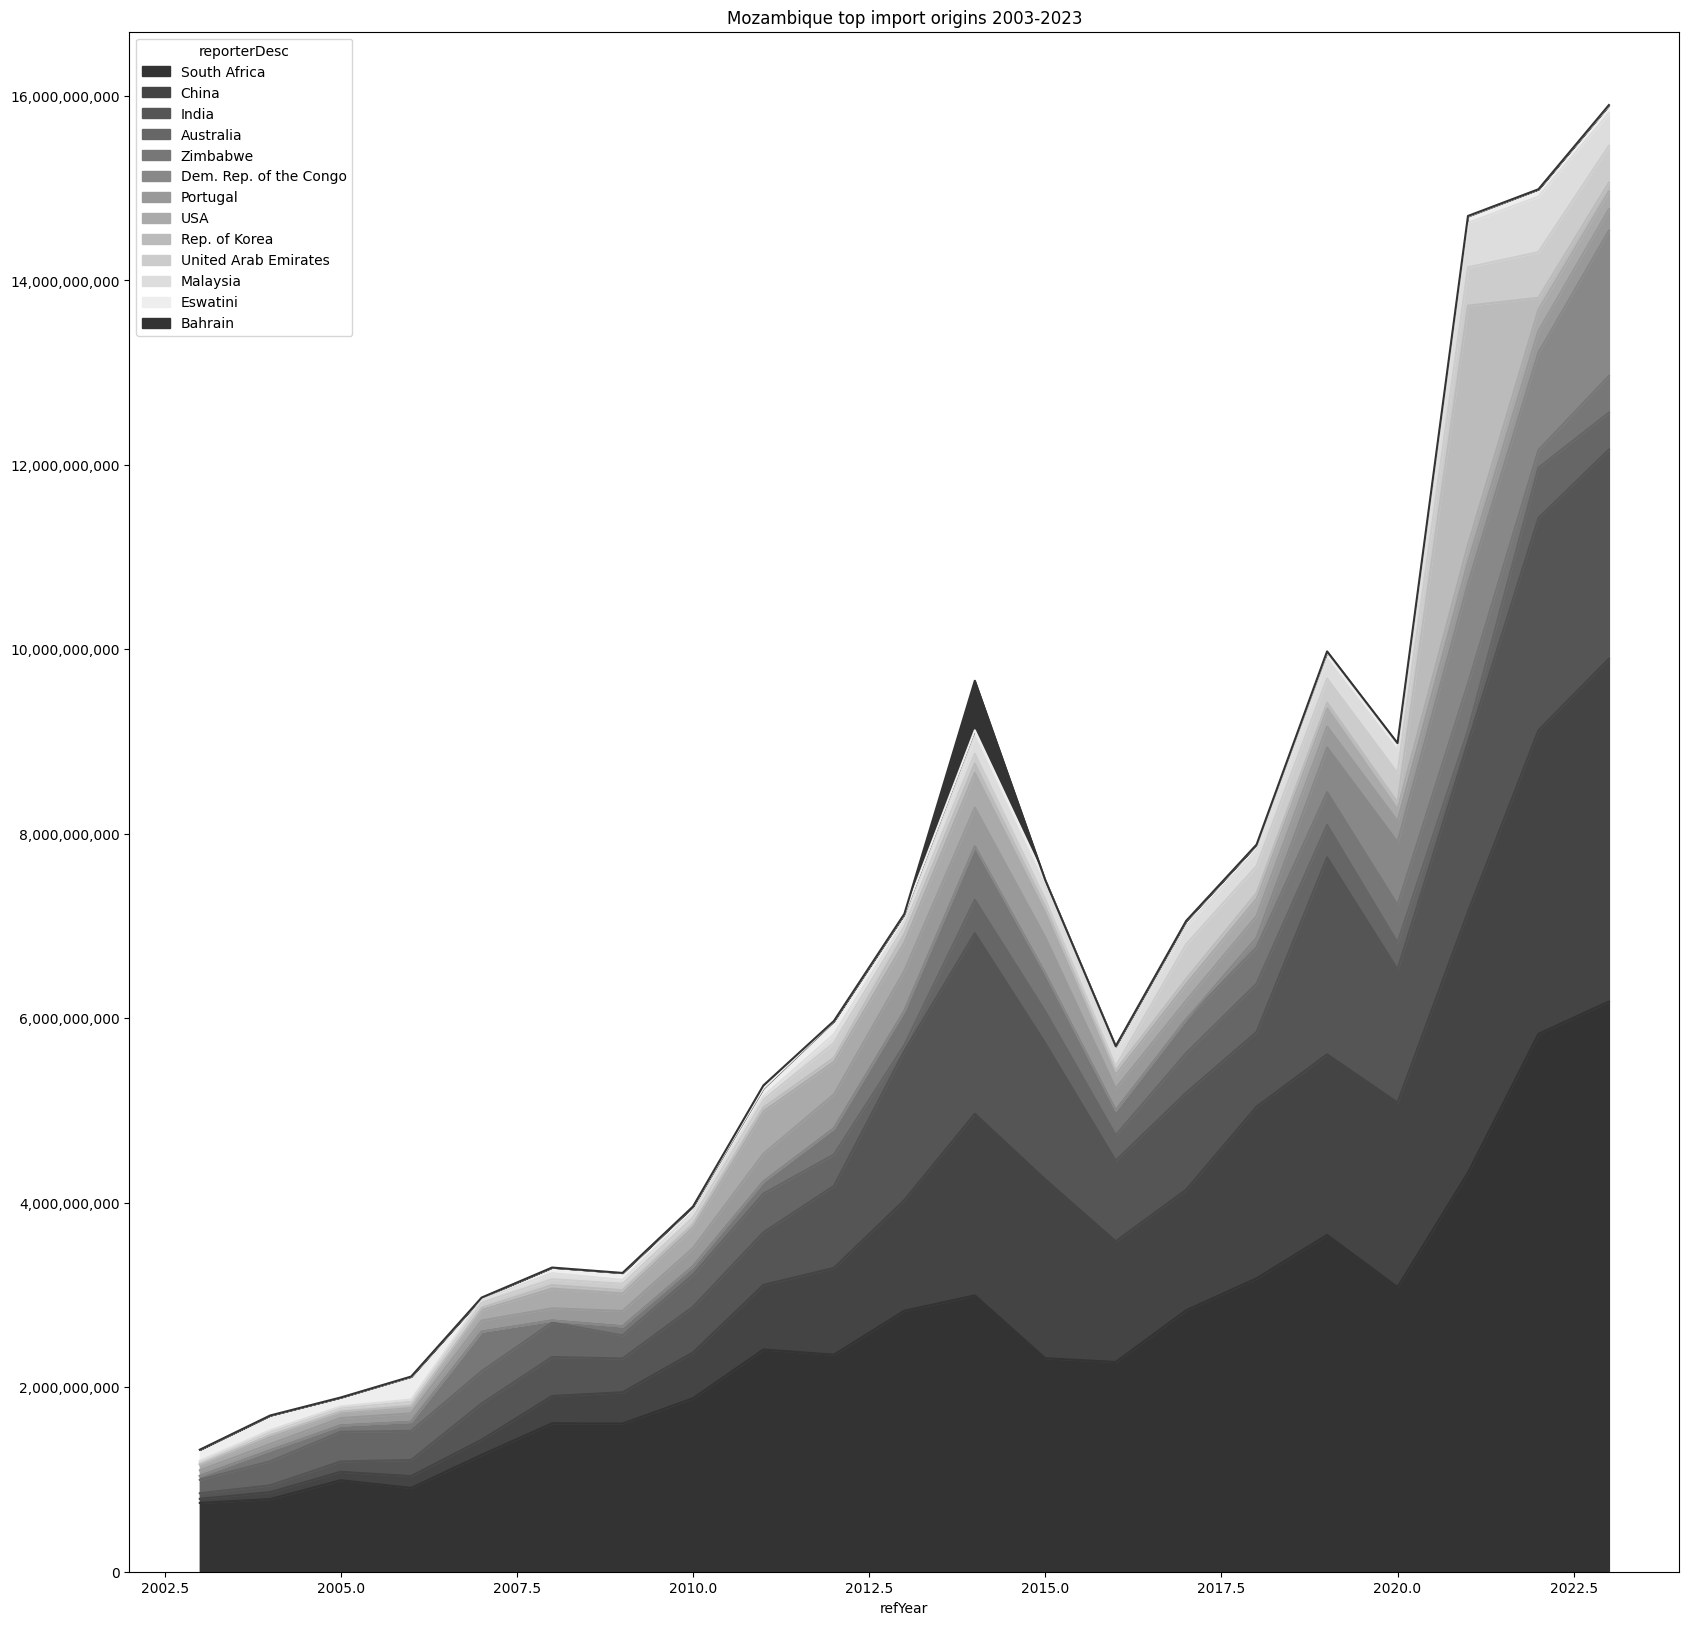

In [152]:
import matplotlib.pyplot as plt

title=f"{country_of_interest_name} top import origins {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_3.1.4_import_partners_{start_year}-{end_year}.png"

# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
# colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
colors = [ '#333333','#444444', '#555555', '#666666', '#777777', '#888888', '#999999', '#AAAAAA', '#BBBBBB', '#CCCCCC', '#DDDDDD', '#EEEEEE']
fig2 = values_only.plot.area(figsize=(20,20),title=title, color=colors)

for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    # print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)

plt.savefig(plotfile)
plt.show()

In [153]:
plotfile

'reports/Mozambique_3.1.4_import_partners_2003-2023.png'

In [154]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_import_partners]
list(show_only_columns)

[('partner_perc', 'Australia'),
 ('partner_perc', 'Bahrain'),
 ('partner_perc', 'China'),
 ('partner_perc', 'Dem. Rep. of the Congo'),
 ('partner_perc', 'Eswatini'),
 ('partner_perc', 'India'),
 ('partner_perc', 'Malaysia'),
 ('partner_perc', 'Portugal'),
 ('partner_perc', 'Rep. of Korea'),
 ('partner_perc', 'South Africa'),
 ('partner_perc', 'USA'),
 ('partner_perc', 'United Arab Emirates'),
 ('partner_perc', 'Zimbabwe'),
 ('primaryValue', 'Australia'),
 ('primaryValue', 'Bahrain'),
 ('primaryValue', 'China'),
 ('primaryValue', 'Dem. Rep. of the Congo'),
 ('primaryValue', 'Eswatini'),
 ('primaryValue', 'India'),
 ('primaryValue', 'Malaysia'),
 ('primaryValue', 'Portugal'),
 ('primaryValue', 'Rep. of Korea'),
 ('primaryValue', 'South Africa'),
 ('primaryValue', 'USA'),
 ('primaryValue', 'United Arab Emirates'),
 ('primaryValue', 'Zimbabwe')]

#### Export to Excel

Table with the top import origins for the period of interest

In [155]:
top_partners_file = f'reports/{country_of_interest_name}_3.1.1_top_import_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_3.1.2_top_import_partners_cols.xlsx'
import_top_partners_file = f'reports/{country_of_interest_name}_3.1.3_import_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

imports[cols].sort_values(['refYear','flowCode','partner_rank']).to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].reset_index().to_excel(import_top_partners_file)

print(f"Top import partners file: {top_partners_file}")
print(f"Top import partners cols file: {top_partners_cols_file}")
print(f"Import top partners file: {import_top_partners_file}")

Top import partners file: reports/Mozambique_3.1.1_top_import_partners.xlsx
Top import partners cols file: reports/Mozambique_3.1.2_top_import_partners_cols.xlsx
Import top partners file: reports/Mozambique_3.1.3_import_top_5_partners_2003-2023.xlsx


### 3.2 Imports: products

#### Main imported products

In [156]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)

print(country_of_interest_name, years_of_interest)


Mozambique 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


Get the products imported by country of interest

In [157]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # keep previous choice for consistency
if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

symmetric_reporting

True

In [166]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6 Equatorial Guinea uses AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )
df.info()

INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005


INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Using cached results for period 2013
INFO:root:Calling getFinalData for period 2014
INFO:root:Using cached results for period 2014
INFO:root:Calling getFinalData for period 2015
INFO:root:Using cached results for period 2015
INFO:root:Cal

/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431757 entries, 0 to 431756
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   typeCode                  431757 non-null  object 
 1   freqCode                  431757 non-null  object 
 2   refPeriodId               431757 non-null  int64  
 3   refYear                   431757 non-null  int64  
 4   refMonth                  431757 non-null  int64  
 5   period                    431757 non-null  object 
 6   reporterCode              431757 non-null  int64  
 7   reporterISO               431757 non-null  object 
 8   reporterDesc              431757 non-null  object 
 9   flowCode                  431757 non-null  object 
 10  flowDesc                  431757 non-null  object 
 11  partnerCode               431757 non-null  int64  
 12  partnerISO                431757 non-null  object 
 13  partnerDesc               431757 non-null  o

In [167]:
print("Years available in the data:", list(df.refYear.unique()))

Years available in the data: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [168]:
cols=['refYear','flowCode','cmdCode', 'cmdDesc','classificationCode','aggrLevel','isLeaf']

df[cols].head()

,refYear,flowCode,cmdCode,cmdDesc,classificationCode,aggrLevel,isLeaf
0,2003,X,020230,"Meat; of bovine animals, boneless cuts, frozen",H2,6,True
1,2003,X,020230,"Meat; of bovine animals, boneless cuts, frozen",H2,6,True
2,2003,X,020712,"Meat and edible offal; of the poultry of heading no. 0105, of fowls of the species gallus domesticus, (not cut in pieces), frozen",H2,6,True
3,2003,X,020714,"Meat and edible offal; of the poultry of heading no. 0105, of fowls of the species gallus domesticus, cuts and offal, frozen",H2,6,True
4,2003,X,020727,"Meat and edible offal; of the poultry of heading no. 0105, of turkeys, cuts and offal, frozen",H2,6,True


Agreggate by product, keep the top products imported each year

In [173]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5
imports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
imports = imports[imports['product_rank']<=show_only_top]
imports.info()

cols=['refYear','flowCode','product_rank','cmdCode', 'cmdDesc','product_sum','product_upper_perc','classificationCode','aggrLevel','isLeaf', 'product_upper_sum']
formats =  comtradetools.make_format(cols)

top_import_products_codes = imports['cmdCode'].unique()

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
imports[cols].sort_values(['refYear','flowCode','product_rank']).head(10).style.format(formats)


<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 25 to 423415
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   typeCode                  105 non-null    object 
 1   freqCode                  105 non-null    object 
 2   refPeriodId               105 non-null    int64  
 3   refYear                   105 non-null    int64  
 4   refMonth                  105 non-null    int64  
 5   period                    105 non-null    object 
 6   reporterCode              105 non-null    int64  
 7   reporterISO               105 non-null    object 
 8   reporterDesc              105 non-null    object 
 9   flowCode                  105 non-null    object 
 10  flowDesc                  105 non-null    object 
 11  partnerCode               105 non-null    int64  
 12  partnerISO                105 non-null    object 
 13  partnerDesc               105 non-null    object 
 14  partner2Cod

,refYear,flowCode,product_rank,cmdCode,cmdDesc,product_sum,product_upper_perc,classificationCode,aggrLevel,isLeaf,product_upper_sum
2507,2003,X,1,271011,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations","$109,614,445",7.101%,H2,6,True,"$1,543,702,873"
25,2003,X,2,100190,Cereals; meslin and wheat other than durum,"$54,143,060",3.507%,H2,6,True,"$1,543,702,873"
2465,2003,X,3,170111,"Sugars; cane sugar, raw, in solid form, not containing added flavouring or colouring matter","$48,532,556",3.144%,H2,6,True,"$1,543,702,873"
696,2003,X,4,100630,"Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed","$34,909,727",2.261%,H2,6,True,"$1,543,702,873"
943,2003,X,5,610990,"T-shirts, singlets and other vests; of textile materials (other than cotton), knitted or crocheted","$28,352,992",1.837%,H2,6,True,"$1,543,702,873"
15669,2004,X,1,271011,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations","$163,212,283",8.583%,H2,6,True,"$1,901,683,503"
12861,2004,X,2,100190,Cereals; meslin and wheat other than durum,"$82,483,178",4.337%,H2,6,True,"$1,901,683,503"
13143,2004,X,3,610910,"T-shirts, singlets and other vests; of cotton, knitted or crocheted","$81,074,258",4.263%,H2,6,True,"$1,901,683,503"
15582,2004,X,4,100630,"Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed","$58,425,649",3.072%,H2,6,True,"$1,901,683,503"
19551,2004,X,5,170111,"Sugars; cane sugar, raw, in solid form, not containing added flavouring or colouring matter","$37,066,921",1.949%,H2,6,True,"$1,901,683,503"


### Caveat

For Angola results match https://trendeconomy.com/data/h2/Angola/TOTAL for AG2 and AG4 but not https://www.statista.com/statistics/1143152/value-of-imports-into-angola-by-category/  and close but not same as https://globaledge.msu.edu/countries/angola/tradestats

The imports match World Bank Wits data mostly, but in some years 
there seems to be a mismatch of HS Codes, with different descriptions in Wits
and values that sometimes match AG4 and not AG6 (2015,total is AG4:2710 not AG6:271012 )
and in same cases match the first 5 digits (2015: 73042 "Casings tubing...", 2021 10011, Durum Wheat)

Use the following cell to compute totals for codes with first 5 digit in common to compare with other sources

In [174]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

code_prefix = '10011'
cols2=['refYear','flowCode','product_rank','cmdCode','cmdDesc','primaryValue','product_perc']

# select rows and columns
selected_rows = df[(df['refYear']==2021) & (df['cmdCode'].str.startswith(code_prefix))][cols2].sort_values(by=['primaryValue'],ascending=False).head(50)

# add total of primaryValue column
total = selected_rows['primaryValue'].sum()
selected_rows.loc['total'] = pd.Series({'primaryValue': total})

# display selected rows
selected_rows


,refYear,flowCode,product_rank,cmdCode,cmdDesc,primaryValue,product_perc
371057,"2,021.00",X,"3,371.00",100119,"Cereals; wheat and meslin, durum wheat, other than seed","12,077.53",0.00
total,NaN,NaN,NaN,NaN,NaN,"12,077.53",NaN


In [175]:
print("Years available in the data:", imports.refYear.unique())

Years available in the data: [2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]


#### Export to Excel

In [177]:
filename = f'reports/{country_of_interest_name}_3.2_imports_products_{clCode}-{cmdDetail}-{imports["refYear"].min()}-{imports["refYear"].max()}.xlsx'
print("Exporting to ",filename)
imports[cols].sort_values(['refYear','flowCode','product_rank']).to_excel(filename,index=False)

Exporting to  reports/Mozambique_3.2_imports_products_HS-AG6-2003-2023.xlsx


### 3.3 Import partners / product analysis

Which are the partners selling the top imports by country of interest

In [184]:
# If symmetric_reporting is "True" we get the exports from
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world
#    for import data from Country of Interest

symmetric_reporting = symmetric_reporting  # keep previous choice

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'X'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'M'
    reporter_column = 'reporter'
    partner_column = 'partner'

In [185]:
import warnings
warnings.filterwarnings('default')

clCode = 'HS'
cmdDetail = 'AG6'  # not all countries report at higher detail

df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        period_size=1, # lots of data, better segment
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        retry_if_empty=False,
                        cache=True
                        )
df.info()

INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using cached results for period 2009
INFO:root:Calling getFinalData for period 2010
INFO:root:Using cached results for period 2010
INFO:root:Calling getFinalData for period 2011
INFO:root:Using cached results for period 2011
INFO:root:Calling getFinalData for period 2012
INFO:root:Using cached results for period 2012
INFO:root:Calling getFinalData for period 2013
INFO:root:Usi

/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431757 entries, 0 to 431756
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   typeCode                  431757 non-null  object 
 1   freqCode                  431757 non-null  object 
 2   refPeriodId               431757 non-null  int64  
 3   refYear                   431757 non-null  int64  
 4   refMonth                  431757 non-null  int64  
 5   period                    431757 non-null  object 
 6   reporterCode              431757 non-null  int64  
 7   reporterISO               431757 non-null  object 
 8   reporterDesc              431757 non-null  object 
 9   flowCode                  431757 non-null  object 
 10  flowDesc                  431757 non-null  object 
 11  partnerCode               431757 non-null  int64  
 12  partnerISO                431757 non-null  object 
 13  partnerDesc               431757 non-null  o

In [186]:
cols2=['refYear','flowCode','reporterDesc','partnerDesc','primaryValue','cmdCode','cmdDesc']
df[cols2].sample(10)

,refYear,flowCode,reporterDesc,partnerDesc,primaryValue,cmdCode,cmdDesc
134877,2011,X,South Africa,Mozambique,"31,178.52",360690,Ferro-cerium and other pyrophoric alloys in all forms; articles of combustible materials n.e.c. in chapter 36
396980,2022,X,South Africa,Mozambique,"77,573.33",382759,"Mixtures containing halogenated derivatives of methane, ethane or propane; containing trifluoromethan (HFC-23) or perfluorocarbons (PFCs) not containing chlorofluorocarbons (CFCs) or hydrochlorofl..."
273621,2017,X,Portugal,Mozambique,"132,335.58",841981,"Machinery, plant and equipment; for making hot drinks, for cooking or heating food"
68511,2007,X,South Africa,Mozambique,"6,814.00",960400,Hand sieves and hand riddles
354988,2020,X,United Kingdom,Mozambique,"11,017.97",300310,"Medicaments; containing penicillins, streptomycins or their derivatives, for therapeutic or prophylactic uses, (not in measured doses, not packaged for retail sale)"
20900,2004,X,South Africa,Mozambique,"62,596.00",440920,"Wood; non-coniferous (including unassembled strips and friezes for parquet flooring), continuously shaped along any edges, ends or faces, whether or not planed, sanded or end-jointed"
257315,2016,X,India,Mozambique,"326,940.00",841989,"Machinery, plant and laboratory equipment; for treating materials by change of temperature, other than for making hot drinks or cooking or heating food"
300245,2018,X,Zimbabwe,Mozambique,"1,340.00",560890,"Twine, cordage or rope; knotted netting, of other than man-made textiles"
280914,2017,X,South Africa,Mozambique,"755,109.62",890399,"Yachts and other vessels; for pleasure or sports, rowing boats and canoes, n.e.c. in heading no. 8903, other than inflatable"
417050,2023,X,Portugal,Mozambique,"5,714.51",520822,"Fabrics, woven; containing 85% or more by weight of cotton, bleached, plain weave, weighing more than 100g/m2 but not more than 200g/m2"


In [187]:
df.refYear.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

Aggregate by partner and keep the main ones

In [188]:
import pandas as pd
import comtradetools
import warnings

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5   # change to have more top partners

print(f"Top products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code'].unique():
    warnings.warn("Removing world from data")
    df = df[df[f'{partner_column}Code']!=0]

products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)
cols=['refYear','flowCode','cmdDesc','cmdCode',f'{partner_column}Desc',f'{prefix}_rank',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats=comtradetools.make_format(cols)

products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_import_products_codes)
                        & (products_and_partners[f'{prefix}_rank']<=show_only_top))]
print(f"Data available for years {products_and_partners.refYear.unique()}")


Top products imported by Mozambique in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['100190' '100630' '610990' '170111' '271011' '610910' '847989' '270119'
 '382490' '271019' '271600' '720241' '811100' '270112' '100199' '271012'
 '300490' '281820' '261000' '999999' '260111' '282200' '890520' '740311']
   100190: 100190
   100630: Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed
   610990: T-shirts, singlets and other vests; of textile materials (other than cotton), knitted or crocheted
   170111: 170111
   271011: 271011
   610910: T-shirts, singlets and other vests; of cotton, knitted or crocheted
   847989: Machines and mechanical appliances; having individual functions, n.e.c. or included in this chapter
   270119: Coal; (other than anthracite and bituminous), whether or not pulverised but not agglomerated
   382490: 382490
   271019: Petroleum oils and oils from bituminous minerals, not con

Data available for years [2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022 2023]


### Partners for main import products

In [189]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True])\
                                            .head(30).style.format(formats) #.hide(axis='index')

,refYear,flowCode,cmdDesc,cmdCode,reporterDesc,cmd_partner_rank,cmd_partner_sum,cmd_partner_perc,cmd_partner_upper_sum
6692,2003,X,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations",271011,South Africa,1,"$104,178,109",95.040%,"$109,614,445"
6691,2003,X,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations",271011,Singapore,2,"$5,430,677",4.954%,"$109,614,445"
3981,2003,X,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations",271011,Portugal,3,"$5,406",0.005%,"$109,614,445"
2507,2003,X,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations",271011,Malawi,4,$174,0.000%,"$109,614,445"
6693,2003,X,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations",271011,Zimbabwe,5,$79,0.000%,"$109,614,445"
12306,2003,X,Cereals; meslin and wheat other than durum,100190,USA,1,"$30,688,195",56.680%,"$54,143,060"
1948,2003,X,Cereals; meslin and wheat other than durum,100190,Germany,2,"$9,831,000",18.157%,"$54,143,060"
25,2003,X,Cereals; meslin and wheat other than durum,100190,Argentina,3,"$4,566,566",8.434%,"$54,143,060"
693,2003,X,Cereals; meslin and wheat other than durum,100190,Canada,4,"$4,247,773",7.845%,"$54,143,060"
1492,2003,X,Cereals; meslin and wheat other than durum,100190,France,5,"$2,071,308",3.826%,"$54,143,060"


In [190]:
filename = f'reports/{country_of_interest_name}_3.3_imports_products_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'
print("Exporting to ",filename)
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                        ascending=[True,True,False,True]).to_excel(filename, index=False)

Exporting to  reports/Mozambique_3.3_imports_products_partners_HS-AG6-2003-2023.xlsx


### 3.4 Main partners and main products imported by country of interest

Detail of the main products by import partner.

Allows to analyse the mix of products of the main suppliers from this country.



In [191]:
top_import_partners

array(['Australia', 'Portugal', 'South Africa', 'Eswatini', 'USA',
       'Zimbabwe', 'China', 'India', 'Bahrain', 'United Arab Emirates',
       'Dem. Rep. of the Congo', 'Rep. of Korea', 'Malaysia'],
      dtype=object)

In [193]:
import comtradetools

show_only_top = 5  # for suppliers with wide range of products e.g PT->AO increase

print(f"Top import partners ({len(top_import_partners)}): {top_import_partners}")
prefix='partner_cmd'
suppliers_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode',f'{partner_column}Desc',f'{prefix}_rank','cmdCode','cmdDesc',f'{prefix}_sum',f'{prefix}_perc',f'{prefix}_upper_sum']
formats = comtradetools.make_format(cols)
suppliers_and_products=suppliers_and_products[(suppliers_and_products[f'{partner_column}Desc'].isin(top_import_partners)
                       & (suppliers_and_products[f'{prefix}_rank']<=show_only_top))]

print("First rows")
suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Top import partners (13): ['Australia' 'Portugal' 'South Africa' 'Eswatini' 'USA' 'Zimbabwe' 'China'
 'India' 'Bahrain' 'United Arab Emirates' 'Dem. Rep. of the Congo'
 'Rep. of Korea' 'Malaysia']
First rows


refYear,flowCode,reporterDesc,partner_cmd_rank,cmdCode,cmdDesc,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2003,X,South Africa,1,271011,"Petroleum oils and oils from bituminous minerals, not crude or waste oils; preparations n.e.c. with 70% or more (weight),of petroleum oils or oils from bituminous minerals; being the basic constituents of the preparations: light oils and preparations","$104,178,109",13.973%,"$745,571,926"
2003,X,South Africa,2,170111,"Sugars; cane sugar, raw, in solid form, not containing added flavouring or colouring matter","$48,524,261",6.508%,"$745,571,926"
2003,X,South Africa,3,870421,"Vehicles; compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a gvw not exceeding 5 tonnes), nes in item no 8704.1","$17,654,672",2.368%,"$745,571,926"
2003,X,South Africa,4,270112,"Coal; bituminous, whether or not pulverised, but not agglomerated","$15,959,202",2.141%,"$745,571,926"
2003,X,South Africa,5,270119,"Coal; (other than anthracite and bituminous), whether or not pulverised but not agglomerated","$15,522,665",2.082%,"$745,571,926"
2003,X,Eswatini,1,610990,"T-shirts, singlets and other vests; of textile materials (other than cotton), knitted or crocheted","$27,862,971",23.062%,"$120,818,301"
2003,X,Eswatini,2,610349,"Trousers, bib and brace overalls, breeches and shorts; men's or boys', of textile materials (other than wool or fine animal hair, cotton or synthetic fibres), knitted or crocheted","$14,255,381",11.799%,"$120,818,301"
2003,X,Eswatini,3,491199,Printed matter; n.e.s. in heading no. 4911,"$12,951,739",10.720%,"$120,818,301"
2003,X,Eswatini,4,440110,"Wood; for fuel, in logs, billets, twigs, faggots or similar forms","$8,066,908",6.677%,"$120,818,301"
2003,X,Eswatini,5,040210,"Dairy produce; milk and cream, concentrated or containing added sugar or other sweetening matter, in powder, granules or other solid forms, of a fat content not exceeding 1.5% (by weight)","$4,486,702",3.714%,"$120,818,301"


Last rows

In [194]:

suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

refYear,flowCode,reporterDesc,partner_cmd_rank,cmdCode,cmdDesc,partner_cmd_sum,partner_cmd_perc,partner_cmd_upper_sum
2023,X,Rep. of Korea,5,390120,"Ethylene polymers; in primary forms, polyethylene having a specific gravity of 0.94 or more","$5,381,006",5.702%,"$94,363,992"
2023,X,Eswatini,1,330210,Odoriferous substances and mixtures; of a kind used in the food or drink industries,"$20,546,422",25.057%,"$82,000,304"
2023,X,Eswatini,2,382499,"Chemical products, mixtures and preparations; n.e.c. heading 3824","$9,702,154",11.832%,"$82,000,304"
2023,X,Eswatini,3,220710,Undenatured ethyl alcohol; of an alcoholic strength by volume of 80% vol. or higher,"$7,989,487",9.743%,"$82,000,304"
2023,X,Eswatini,4,220830,Whiskies,"$5,928,544",7.230%,"$82,000,304"
2023,X,Eswatini,5,230990,"Dog or cat food; (not put up for retail sale), used in animal feeding","$4,670,727",5.696%,"$82,000,304"
2023,X,Bahrain,1,760511,"Aluminium; (not alloyed), wire, maximum cross-sectional dimension exceeds 7mm","$4,753,405",96.030%,"$4,949,904"
2023,X,Bahrain,2,760612,"Aluminium; plates, sheets and strip, thickness exceeding 0.2mm, alloys, rectangular (including square)","$140,885",2.846%,"$4,949,904"
2023,X,Bahrain,3,721710,"Iron or non-alloy steel; wire, (not plated or coated), whether or not polished","$36,560",0.739%,"$4,949,904"
2023,X,Bahrain,4,841790,"Furnaces and ovens; parts of non-electric furnaces and ovens (including incinerators), of industrial or laboratory use","$19,054",0.385%,"$4,949,904"


#### Export to Excel

In [195]:
filename = f'reports/{country_of_interest_name}_3.4_imports_partners_products_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx'

suppliers_and_products[suppliers_and_products[f'{prefix}_rank']<=show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).to_excel(filename, index=False)

print("Exporting to ",filename)

Exporting to  reports/Mozambique_3.4_imports_partners_products_HS-AG6-2003-2023.xlsx


### 3.5 Get the alternative clients for country of interest suppliers

For each year, supplier, imported commodity, fetch all the 
exports of the commodity by the supplier to other countries, and
compute the ranking of country of interest among the clients
of partner for that commodity.

Country of interest: Angola, in 2022 Argentina was #1 supplier of Angola for commodity
code 100119 "Cereals; wheat and meslin, durum wheat, other than seed"; fetch all the clients of Argentina for 100119 and compute the ranking of Angola.

First step is to get the combos os partner and commodity.



In [196]:
top_import_products_codes

array(['100190', '100630', '610990', '170111', '271011', '610910',
       '847989', '270119', '382490', '271019', '271600', '720241',
       '811100', '270112', '100199', '271012', '300490', '281820',
       '261000', '999999', '260111', '282200', '890520', '740311'],
      dtype=object)

In [197]:
top_import_partners_codes, partner_column

(array([ 36, 620, 710, 748, 842, 716, 156, 699,  48, 784, 180, 410, 458]),
 'reporter')

In [198]:
suppliers_and_products[[f"{partner_column}Desc",f"{partner_column}Code",'cmdCode']].sample(10)

,reporterDesc,reporterCode,cmdCode
84616,Eswatini,748,220820
72947,China,156,732591
208258,South Africa,710,720241
71354,Australia,36,630900
73537,China,156,871110
180949,Zimbabwe,716,170112
364443,Rep. of Korea,410,300490
413484,Malaysia,458,151110
396075,India,699,271012
87537,Bahrain,48,040630


In [199]:
combos_of_interest = suppliers_and_products[(suppliers_and_products['cmdCode'].isin(top_import_products_codes)
                & (suppliers_and_products[f'{partner_column}Code'].isin(top_import_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

54

In [200]:
# create lists of commodities codes and country codes to query comtrade
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

Get the all clients of suppliers for the products imported by country of interest

In [201]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='X',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=1,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                retry_if_empty=False,
                                cache=True,

                                )

Years of interest:  2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
countryCodeCSV:  36,710,842,458,716,620,748,784,48,180,410,699,156
cmdCodeCSV:  271011,610910,170111,100199,271019,720241,261000,300490,270112,610990,100190,282200,260111,999999,890520,382490,270119,100630,281820,811100,847989,271600,271012,740311
INFO:root:Calling getFinalData for period 2003
INFO:root:Using cached results for period 2003
INFO:root:Calling getFinalData for period 2004
INFO:root:Using cached results for period 2004
INFO:root:Calling getFinalData for period 2005
INFO:root:Using cached results for period 2005
INFO:root:Calling getFinalData for period 2006
INFO:root:Using cached results for period 2006
INFO:root:Calling getFinalData for period 2007
INFO:root:Using cached results for period 2007
INFO:root:Calling getFinalData for period 2008
INFO:root:Using cached results for period 2008
INFO:root:Calling getFinalData for period 2009
INFO:root:Using 

/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


INFO:root:Using cached results for period 2018
INFO:root:Calling getFinalData for period 2019
INFO:root:Using cached results for period 2019
INFO:root:Calling getFinalData for period 2020
INFO:root:Using cached results for period 2020
INFO:root:Calling getFinalData for period 2021
INFO:root:Using cached results for period 2021
INFO:root:Calling getFinalData for period 2022
INFO:root:Using cached results for period 2022
INFO:root:Calling getFinalData for period 2023
INFO:root:Using cached results for period 2023


/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)
/workspaces/cipf-comtrade/comtradetools.py:658: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp], ignore_index=True)


Countries also buying top imports of country of interest from the same suppliers

In [202]:
list(df.reporterDesc.unique()), list(df.partnerDesc.unique())


(['Australia',
  'Bahrain',
  'China',
  'Rep. of Korea',
  'Malaysia',
  'Portugal',
  'South Africa',
  'India',
  'Zimbabwe',
  'United Arab Emirates',
  'Eswatini',
  'USA',
  'Dem. Rep. of the Congo'],
 ['Albania',
  'Afghanistan',
  'Antarctica',
  'Algeria',
  'American Samoa',
  'Azerbaijan',
  'Angola',
  'Argentina',
  'Bahamas',
  'Austria',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belgium',
  'Bhutan',
  'Bolivia (Plurinational State of)',
  'Brazil',
  'Solomon Isds',
  'Br. Virgin Isds',
  'Brunei Darussalam',
  'Bulgaria',
  'Myanmar',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cayman Isds',
  'Sri Lanka',
  'Chad',
  'Chile',
  'China',
  'Christmas Isds',
  'Cocos Isds',
  'Colombia',
  'Congo',
  'Cook Isds',
  'Costa Rica',
  'Croatia',
  'Cyprus',
  'Cuba',
  'Czechia',
  'Benin',
  'Equatorial Guinea',
  'Denmark',
  'Eritrea',
  'Estonia',
  'Ethiopia',
  'Fiji',
  'Finland',
  'France',
  'French Polynesia',
  'Fr. South Antarctic Terr.',
  'Djibouti',
  'Ge

### Ranking of country of interest in the costumers of main suppliers
Allows assessment of the importance of country of interest for the partners
that are selling its main imports.

It allows for restricting rank, avoiding irrelevant matchess

For each supplier show the top costumers of the products bought by country of interest. 

If country of interest is not in the top five constumers, show position anyway if it is a supplier in the given year 

In [203]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_costumers = comtradetools.total_rank_perc(
                                        df,
                                        groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                        col='primaryValue',
                                        prefix='cmd_partner',
                                        )

other_costumers = other_costumers[other_costumers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','cmdCode','cmdDesc','refYear','partnerDesc','cmd_partner_rank','primaryValue','cmd_partner_perc','cmd_partner_upper_sum']
formats =  comtradetools.make_format(cols)

other_costumers[(other_costumers['partnerCode'] == country_of_interest)
                | (other_costumers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Australia,100190,Cereals; meslin and wheat other than durum,2003,"Areas, nes",1,"$1,521,018,986",98.475%,"$1,544,575,584"
Australia,100190,Cereals; meslin and wheat other than durum,2003,New Caledonia,2,"$4,067,187",0.263%,"$1,544,575,584"
Australia,100190,Cereals; meslin and wheat other than durum,2003,New Zealand,3,"$3,766,686",0.244%,"$1,544,575,584"
Australia,100190,Cereals; meslin and wheat other than durum,2003,Malaysia,4,"$2,870,165",0.186%,"$1,544,575,584"
Australia,100190,Cereals; meslin and wheat other than durum,2003,Viet Nam,5,"$2,406,669",0.156%,"$1,544,575,584"
Australia,100190,Cereals; meslin and wheat other than durum,2004,"Areas, nes",1,"$2,898,155,348",96.196%,"$3,012,753,405"
Australia,100190,Cereals; meslin and wheat other than durum,2004,Viet Nam,2,"$37,682,471",1.251%,"$3,012,753,405"
Australia,100190,Cereals; meslin and wheat other than durum,2004,Malaysia,3,"$17,666,535",0.586%,"$3,012,753,405"
Australia,100190,Cereals; meslin and wheat other than durum,2004,New Zealand,4,"$11,348,443",0.377%,"$3,012,753,405"
Australia,100190,Cereals; meslin and wheat other than durum,2004,Myanmar,5,"$10,023,851",0.333%,"$3,012,753,405"


In [204]:
ignore_if_rank_is_higher = 25

relevant_for_partner_exports=other_costumers[
    (other_costumers['partnerCode'] == country_of_interest) &
    (other_costumers['cmd_partner_rank'] < ignore_if_rank_is_higher)
][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank'])
relevant_for_partner_exports.head(10).style.format(formats).hide(axis='index')

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,primaryValue,cmd_partner_perc,cmd_partner_upper_sum
Australia,100190,Cereals; meslin and wheat other than durum,2011,Mozambique,23,"$28,714,549",0.465%,"$6,176,348,934"
Australia,100199,"Cereals; wheat and meslin, other than durum wheat, other than seed",2012,Mozambique,24,"$38,429,587",0.576%,"$6,671,287,534"
Australia,100199,"Cereals; wheat and meslin, other than durum wheat, other than seed",2013,Mozambique,23,"$56,028,216",0.968%,"$5,786,553,327"
Australia,100199,"Cereals; wheat and meslin, other than durum wheat, other than seed",2021,Mozambique,20,"$76,954,508",1.106%,"$6,959,092,280"
Australia,100199,"Cereals; wheat and meslin, other than durum wheat, other than seed",2022,Mozambique,23,"$55,942,733",0.567%,"$9,862,923,679"
Australia,281820,Aluminium oxide; other than artificial corundum,2015,Mozambique,3,"$71,588,137",1.475%,"$4,854,065,461"
Australia,281820,Aluminium oxide; other than artificial corundum,2016,Mozambique,4,"$255,933,565",6.238%,"$4,103,103,018"
Australia,281820,Aluminium oxide; other than artificial corundum,2017,Mozambique,3,"$374,703,020",6.670%,"$5,617,847,410"
Australia,281820,Aluminium oxide; other than artificial corundum,2018,Mozambique,3,"$505,289,161",6.741%,"$7,495,789,993"
Australia,281820,Aluminium oxide; other than artificial corundum,2019,Mozambique,3,"$342,518,175",5.971%,"$5,736,111,068"


#### Export to Excel


In [205]:
filename = filename = f'reports/{country_of_interest_name}_3.5.1_import_partners_alternative.xlsx'

other_costumers[(other_costumers['partnerCode'] == country_of_interest)
                | (other_costumers['cmd_partner_rank']<=show_only_top)
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Mozambique_3.5.1_import_partners_alternative.xlsx


In [206]:
filename = f'reports/{country_of_interest_name}_3.5.2_import_partners_alternative_relevant.xlsx'

relevant_for_partner_exports.to_excel(filename, index=False)
print("Exporting to ",filename)

Exporting to  reports/Mozambique_3.5.2_import_partners_alternative_relevant.xlsx


In [207]:
from datetime import datetime

current_datetime = datetime.now()
print(f"End run for {country_of_interest_name}:", current_datetime)

End run for Mozambique: 2025-04-19 05:05:47.783868


In [208]:
"Done"

'Done'